# (25) Dataloder -- & Dataset

**Motivation**: Create dataloaders, next I will be ready to fit. <br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from figures.fighelper import *
from model.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer

In [2]:
from model.vae2d import VAE
from model.train import TrainerVAE

from torch import _dynamo
_dynamo.config.cache_size_limit = 1024

In [3]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=3, n_groups_per_scale=20, n_latent_per_group=3,
    n_pre_blocks=0, n_post_cells=3, n_cells_per_cond=2,
    ada_groups=True, spectral_norm=0,
))
tr = TrainerVAE(
    model=torch.compile(vae),
    # model=vae,
    cfg=ConfigTrain(
        lr=0.001, batch_size=512, epochs=1000, grad_clip=1000, warmup_portion=0.1,
        lambda_anneal=True, lambda_norm=1e-5, optimizer_kws={'eps': 1e-8},
        kl_beta=0.25, kl_anneal_cycles=1),
    device='cuda:2',
)
vae.cfg.total_latents()

105

In [4]:
vae.print()
vae.scales

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |  10.9 Mil  |
|     ---     |    ---     |
|     stem    |   1.1 K    |
|     pre     |     0      |
|  enc_tower  |  5.6 Mil   |
| enc_sampler |  1.3 Mil   |
| dec_sampler |  1.3 Mil   |
|    expand   |   52.7 K   |
|  dec_tower  |  2.6 Mil   |
|     post    |   10.3 K   |
|     out     |    290     |
|  cos_recon  |     0      |
|   l2_recon  |     0      |
|   l1_recon  |     0      |
|  l1_weight  |     0      |
+-------------+------------+

[16, 8, 4]

In [5]:
vae.latent_scales()[1]

{'idx-0_scale-4_group-0': range(0, 3),
 'idx-1_scale-4_group-1': range(3, 6),
 'idx-2_scale-4_group-2': range(6, 9),
 'idx-3_scale-4_group-3': range(9, 12),
 'idx-4_scale-4_group-4': range(12, 15),
 'idx-5_scale-8_group-0': range(15, 18),
 'idx-6_scale-8_group-1': range(18, 21),
 'idx-7_scale-8_group-2': range(21, 24),
 'idx-8_scale-8_group-3': range(24, 27),
 'idx-9_scale-8_group-4': range(27, 30),
 'idx-10_scale-8_group-5': range(30, 33),
 'idx-11_scale-8_group-6': range(33, 36),
 'idx-12_scale-8_group-7': range(36, 39),
 'idx-13_scale-8_group-8': range(39, 42),
 'idx-14_scale-8_group-9': range(42, 45),
 'idx-15_scale-16_group-0': range(45, 48),
 'idx-16_scale-16_group-1': range(48, 51),
 'idx-17_scale-16_group-2': range(51, 54),
 'idx-18_scale-16_group-3': range(54, 57),
 'idx-19_scale-16_group-4': range(57, 60),
 'idx-20_scale-16_group-5': range(60, 63),
 'idx-21_scale-16_group-6': range(63, 66),
 'idx-22_scale-16_group-7': range(66, 69),
 'idx-23_scale-16_group-8': range(69, 72),


In [6]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(229, 225)

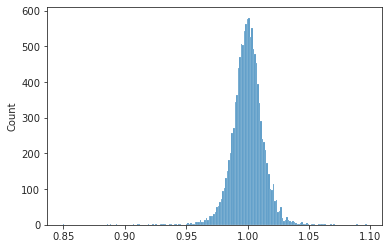

In [7]:
all_norm = torch.cat(vae.all_log_norm)
all_norm = torch.exp(all_norm)
sns.histplot(to_np(all_norm), bins=200);

In [8]:
tr.alphas = None

## Review train options

In [9]:
print(f"VAE:\t\t{vae.cfg.name()}\nTrainer:\t{tr.cfg.name()}")

VAE:            k-32_z-3x[5,10,20]_cells-2_post-1x3
Trainer:        ep1000-b512-lr(0.001)_beta(0.25)-anneal(1x0.3)_lambda(1e-05)_grad(1000)

## Train

In [ ]:
comment = f"kl:NoBal-warmup:0.1_{tr.cfg.name()}"
tr.train(comment=comment)

epoch # 255, avg loss: 15.873545:  26%|██▌       | 255/1000 [6:00:35<17:39:21, 85.32s/it]  

In [ ]:
all_norm = [torch.exp(n.ravel()) for n in vae.all_log_norm]
all_norm = to_np(torch.cat(all_norm))
sns.histplot(all_norm, bins=np.linspace(0, 5, 101));

In [ ]:
np.max(all_norm), (all_norm > 5).sum() / len(all_norm)

In [12]:
val, loss = tr.validate(n_samples=4096)
{k: v.mean() for k, v in loss.items()}

{'kl': 11300.598,
 'l1': 0.77027786,
 'l2': 0.3192796,
 'epe': 2.5017679,
 'cos': 6.501758}

In [13]:
vae.cfg.name()

'k-32_z-3x[5,10,20]_cells-2_post-1x3_sn-1'

fig/sample

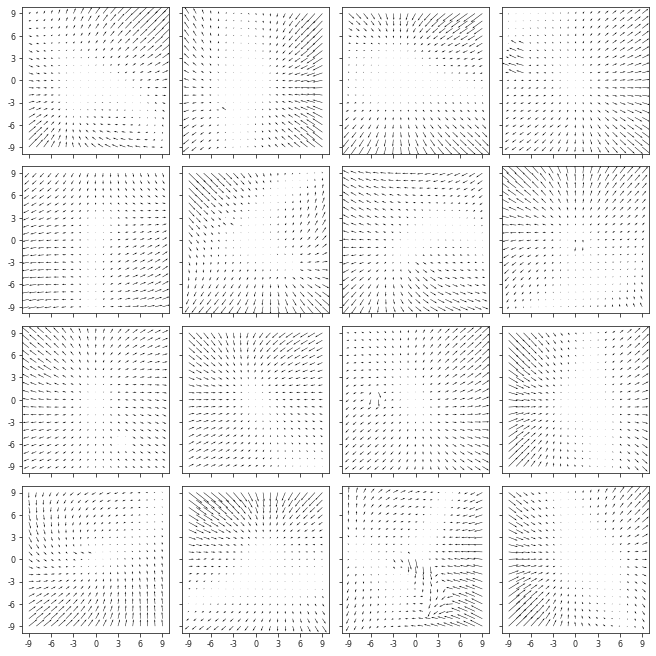

fig/corr_z

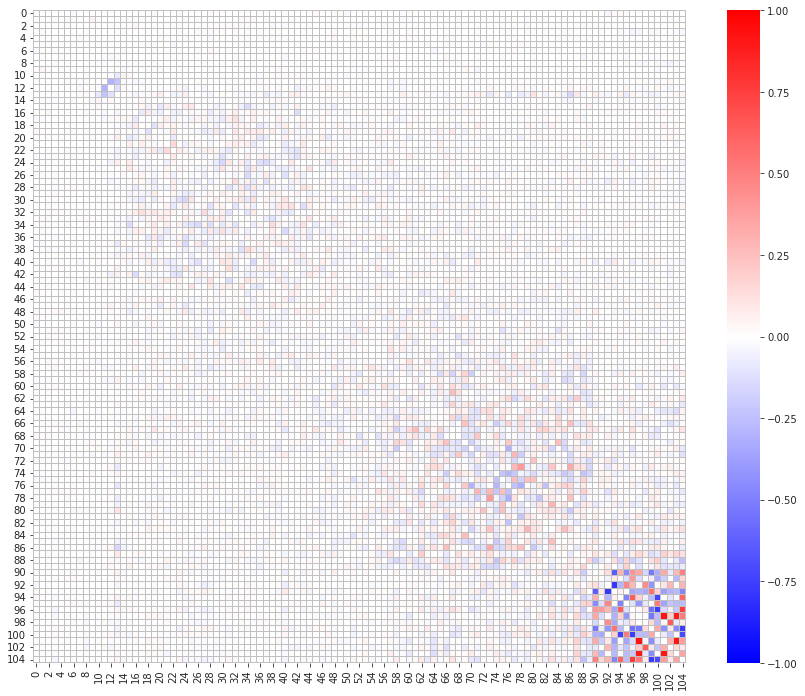

fig/regression

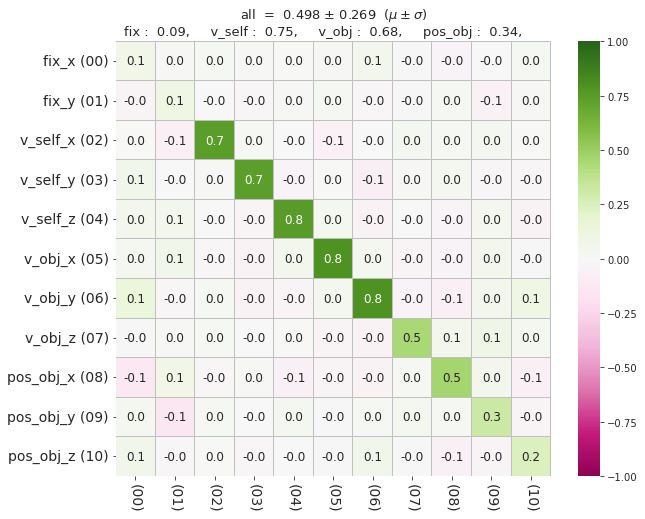

fig/mutual_info

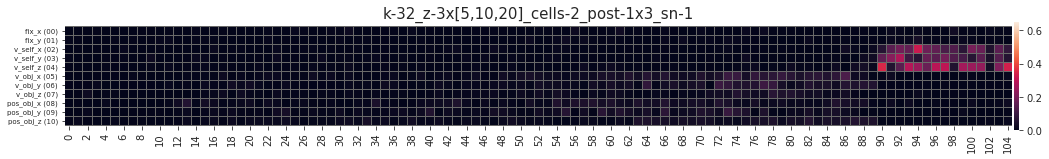

fig/hist_z

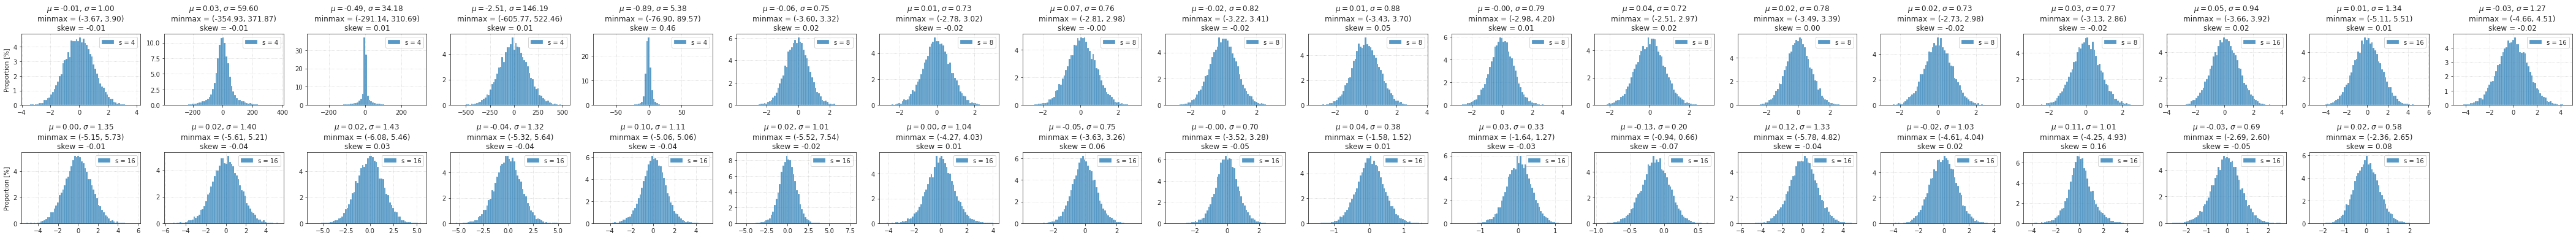

fig/hist_x_sample

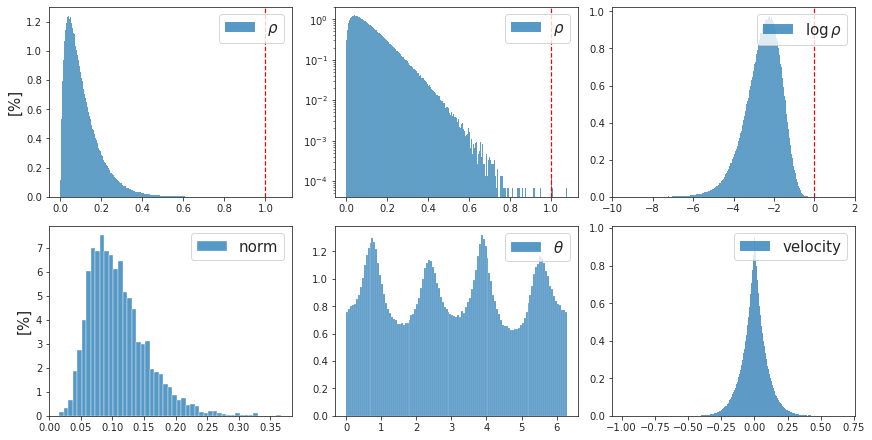

In [14]:
for k, v in val.items():
    if 'fig' in k:
        print(k)
        display(v)

'k-48_z-3x[5,10,20]_cells-2_post-1x3'

{'kl': 39.747368,
 'l1': 0.69956297,
 'l2': 0.25760844,
 'epe': 2.5846183,
 'cos': 4.840898}

fig/sample

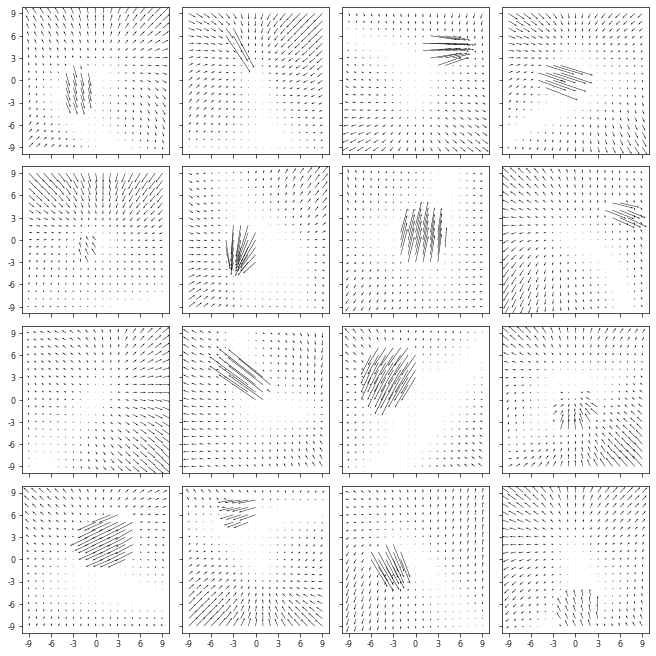

fig/corr_z

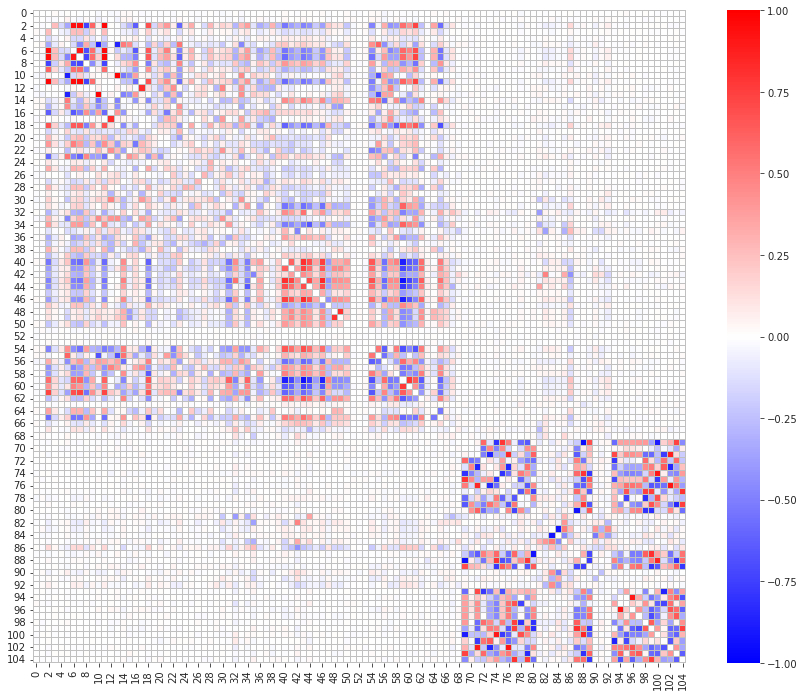

fig/regression

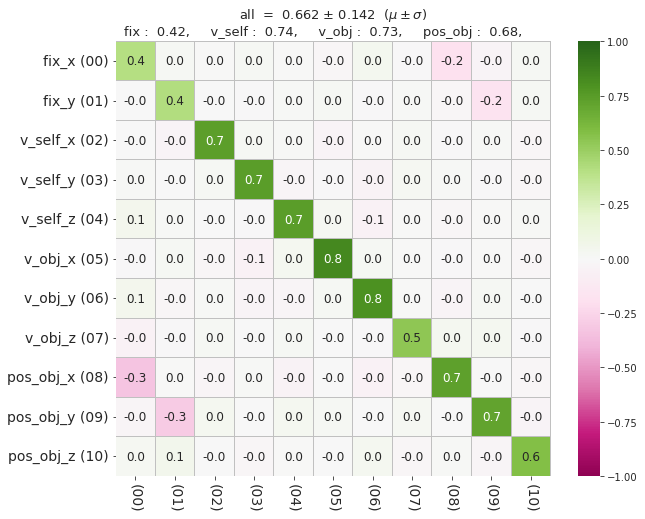

fig/mutual_info

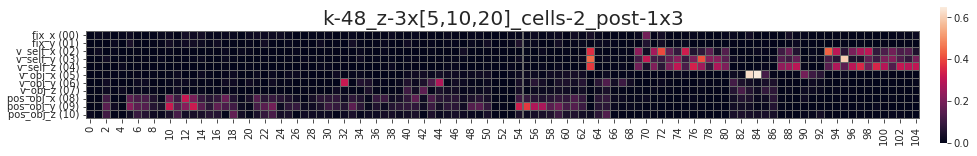

fig/hist_z

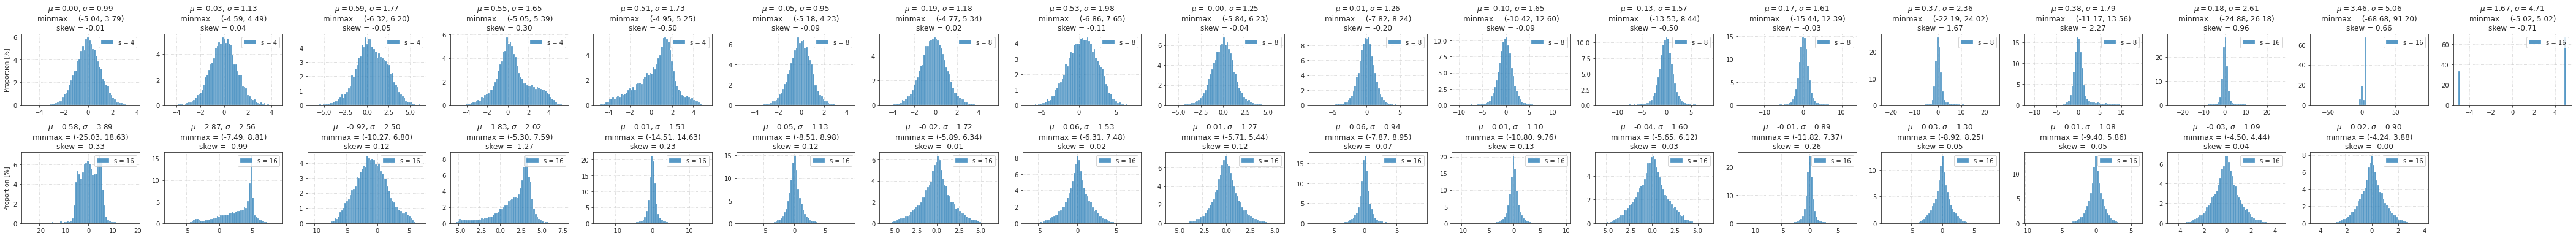

fig/hist_x_sample

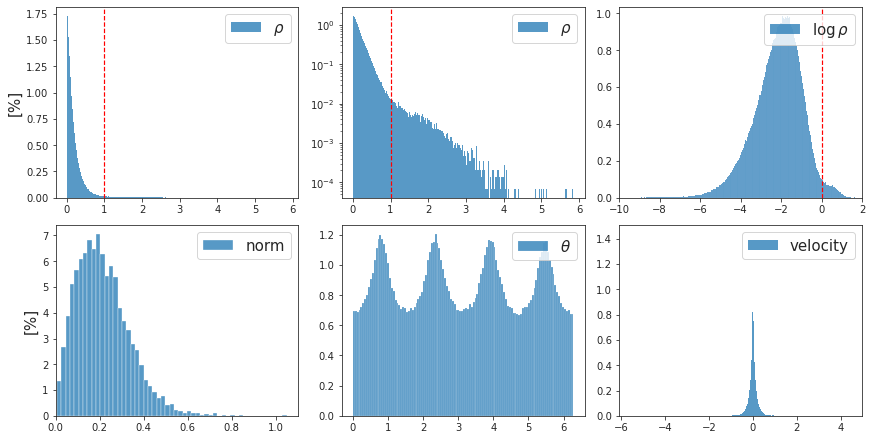

fig/sample

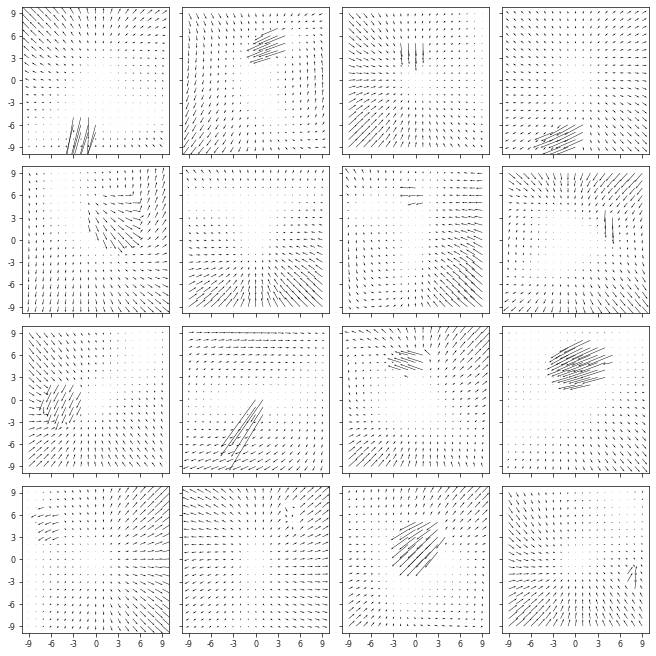

fig/corr_z

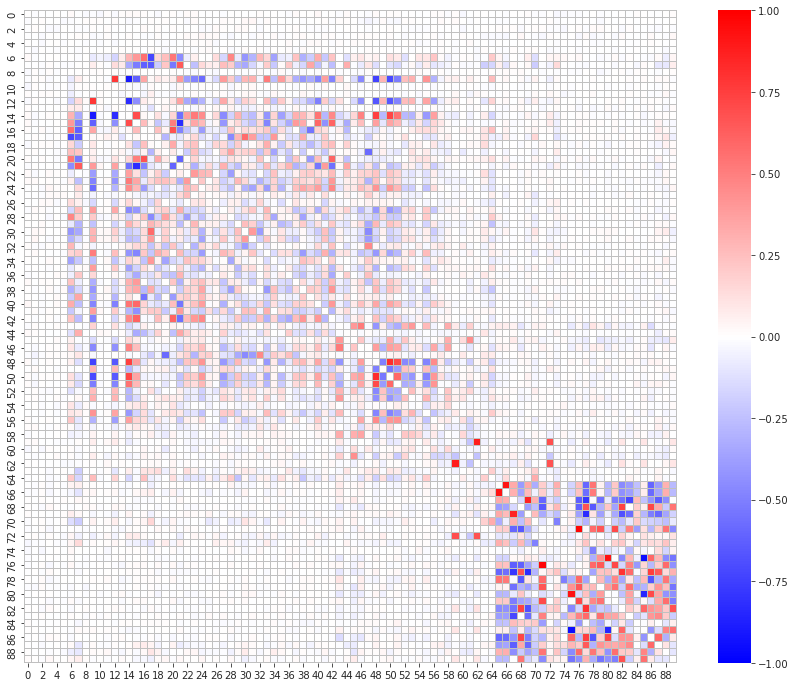

fig/regression

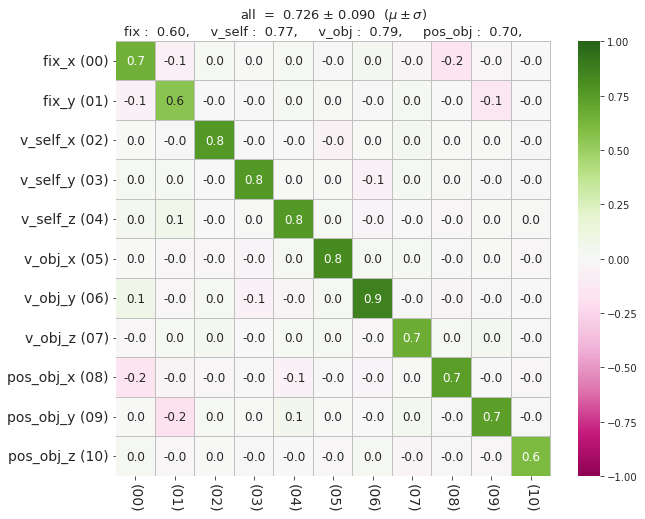

fig/mutual_info

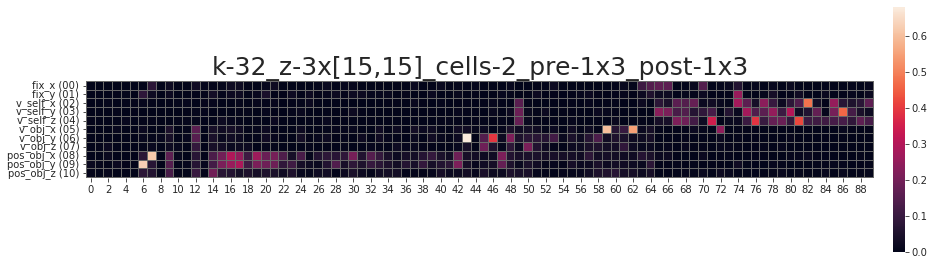

fig/hist_z

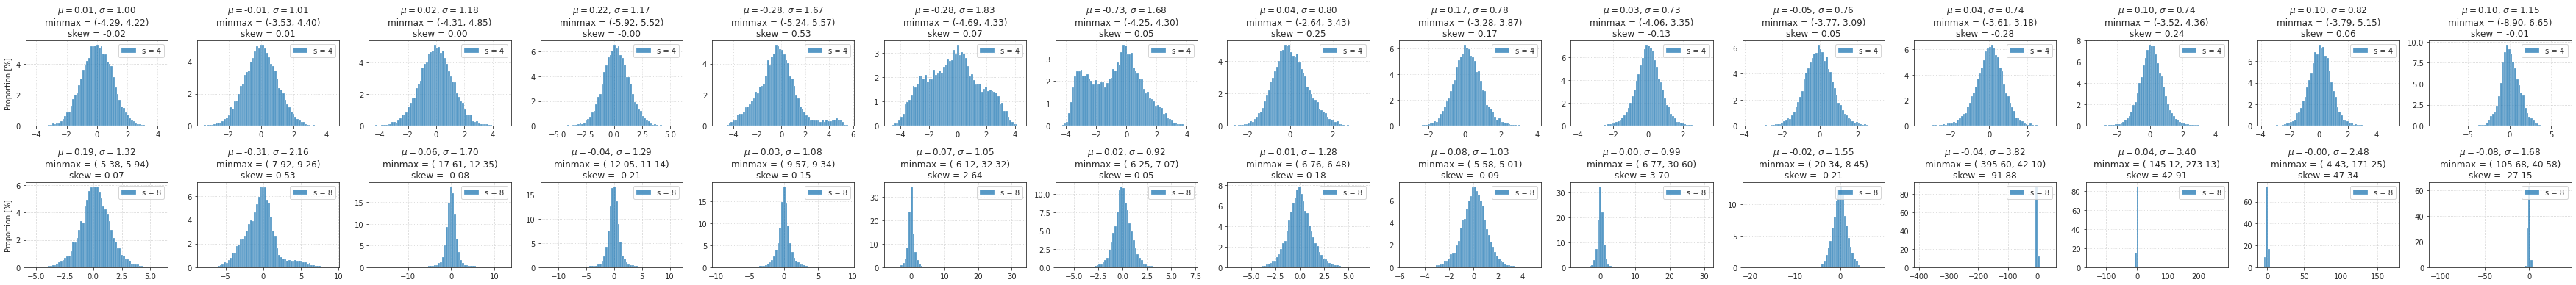

fig/hist_x_sample

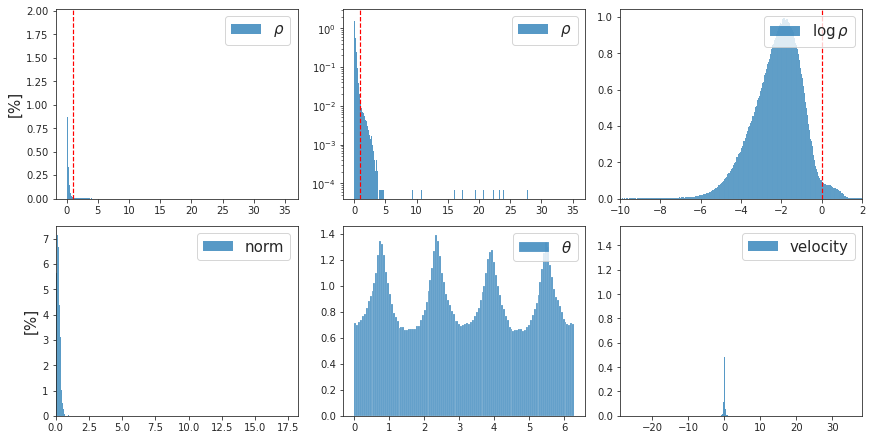

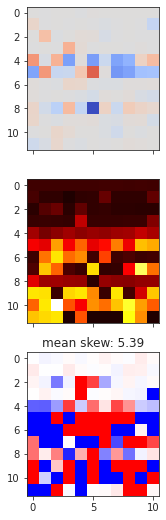

In [14]:
z = val['z_sample']
scales=vae.latent_scales()[0]
a = z.reshape((len(z), len(scales), -1))
nrows, ncols = a.shape[1:]
looper = itertools.product(
    range(nrows), range(ncols))
mu = np.zeros((nrows, ncols))
std = np.zeros((nrows, ncols))
skew = np.zeros((nrows, ncols))
for i, j in looper:
    x = a[:, i, j]
    mu[i, j] = x.mean()
    std[i, j] = x.std()
    skew[i, j] = sp_stats.skew(x)

    
fig, axes = create_figure(3, 1, (22, 9), 'all', 'all')
axes[0].imshow(mu, vmin=-3, vmax=3, cmap='coolwarm')
axes[1].imshow(std, vmin=0, cmap='hot')
axes[2].imshow(skew, vmin=-1, vmax=1, cmap='bwr')
axes[2].set_title(f"mean skew: {np.abs(skew).mean():0.2f}")
plt.show()

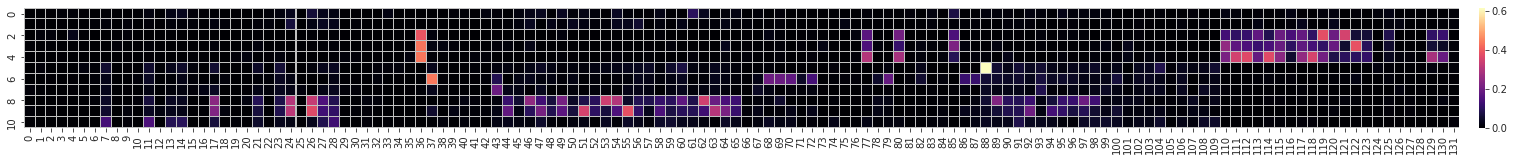

In [16]:
show_heatmap(val['regr/mi'], vmin=0, vmax=None, cmap='magma',
             annot=False, cbar_kws={'pad': 0.005}, figsize=(70, 2.2));

In [17]:
val['regr/mi'].shape

(11, 132)

In [18]:
mi = val['regr/mi']
mi.shape

(11, 132)

In [19]:
scales, level_ids = vae.latent_scales()

In [20]:
level_ids

{'group-0_scale-4_0': range(0, 11),
 'group-1_scale-4_1': range(11, 22),
 'group-2_scale-4_2': range(22, 33),
 'group-3_scale-4_3': range(33, 44),
 'group-4_scale-8_0': range(44, 55),
 'group-5_scale-8_1': range(55, 66),
 'group-6_scale-8_2': range(66, 77),
 'group-7_scale-8_3': range(77, 88),
 'group-8_scale-16_0': range(88, 99),
 'group-9_scale-16_1': range(99, 110),
 'group-10_scale-16_2': range(110, 121),
 'group-11_scale-16_3': range(121, 132)}

In [21]:
mi_scales = np.zeros((len(mi), len(level_ids)))
for j, (key, ids) in enumerate(level_ids.items()):
    for i, x in enumerate(mi):
        mi_scales[i, j] = x[ids].sum() / x.sum()
mi_scales.shape

(11, 12)

In [22]:
names = tr.dl_tst.dataset.factor_names
_ty = [f"{e} ({i:02d})" for i, e in names.items()]
_tx = [e.split('_')[1] for e in level_ids]

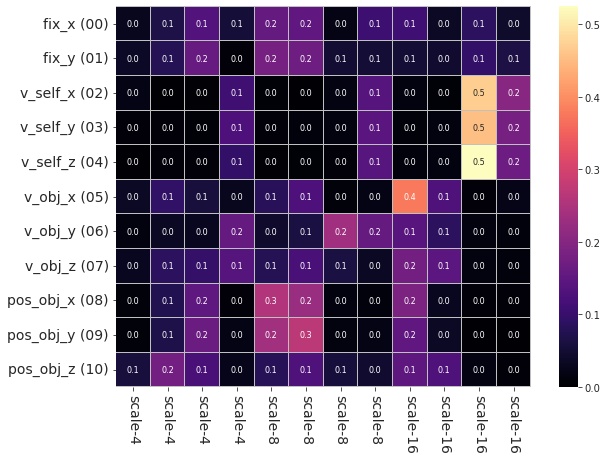

In [24]:
show_heatmap(
    r=mi_scales,
    vmin=0,
    vmax=None,
    yticklabels=_ty,
    xticklabels=_tx,
    cmap='magma',
    figsize=(10, 7),
);

In [25]:
mi_scales2 = np.zeros((len(mi), len(vae.cfg.groups)))
for j, s in enumerate(np.unique(scales)):
    _ids = []
    for k, ids in level_ids.items():
        if f'scale-{s}' in k:
            _ids.extend(list(ids))
    for i, x in enumerate(mi):
        mi_scales2[i, j] = x[_ids].sum() / x.sum()

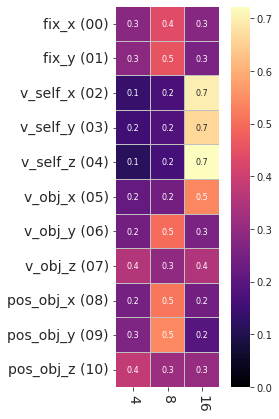

In [26]:
show_heatmap(
    r=mi_scales2,
    vmin=0,
    vmax=None,
    yticklabels=_ty,
    xticklabels=np.unique(scales),
    cmap='magma',
    figsize=(4, 7),
);

In [29]:
u, s, v = sp_lin.svd(
    a=val['z_sample'],
    full_matrices=False,
    compute_uv=True,
)
s *= 100 / s.sum()
u.shape, s.shape, v.shape

((4096, 132), (132,), (132, 132))

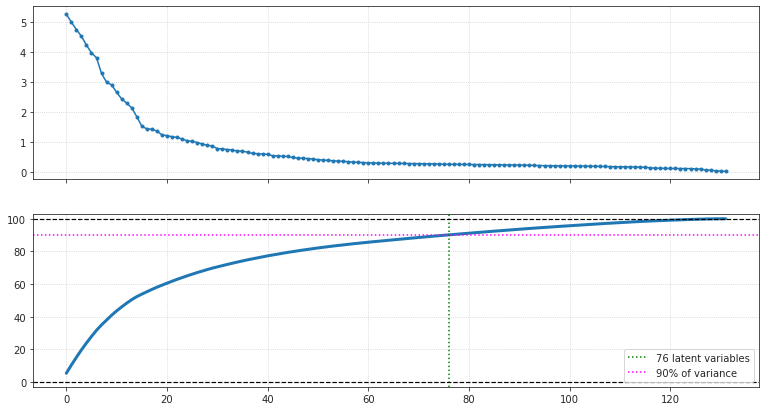

In [76]:
fig, axes = create_figure(2, 1, (13, 7), sharex='all')
axes[0].plot(s, marker='.')
axes[1].plot(np.cumsum(s), lw=3, marker=None)

idx = np.where(np.cumsum(s) > 90)[0][0]
axes[1].axvline(
    idx, color='g', ls=':', lw=1.5,
    label=f'{idx} latent variables',
)
axes[1].axhline(
    90, color='magenta', ls=':', lw=1.5,
    label=f'{90}% of variance',
)
axes[1].legend()

axes[1].axhline(0, color='k', ls='--', lw=1.2)
axes[1].axhline(100, color='k', ls='--', lw=1.2)
axes[1].set_ylim((-3, 103))
add_grid(axes)
plt.show()


76

In [ ]:




fig, ax = create_figure(figsize=(8, 3))
ax.plot(s, marker='o')
ax.set(xticks=ticks, xticklabels=ticklabels)
ax.grid()

In [50]:
x, norm = next(iter(tr.dl_tst))
x, norm = tr.to([x, norm])
w = 1 / norm

In [51]:
tr.model.eval();
with torch.no_grad():
    y, *_ = tr.model(x)

In [52]:
l1 = tr.model.l1_recon(x, y)
l1 = torch.sum(l1, dim=[1, 2, 3])
l1_bal = l1 * w / w.mean()
l1_bal = to_np(l1_bal)
l1 = to_np(l1)
l1.shape

(256,)

In [53]:
np.argmax(l1)

70

In [54]:
np.argmax(l1_bal)

71

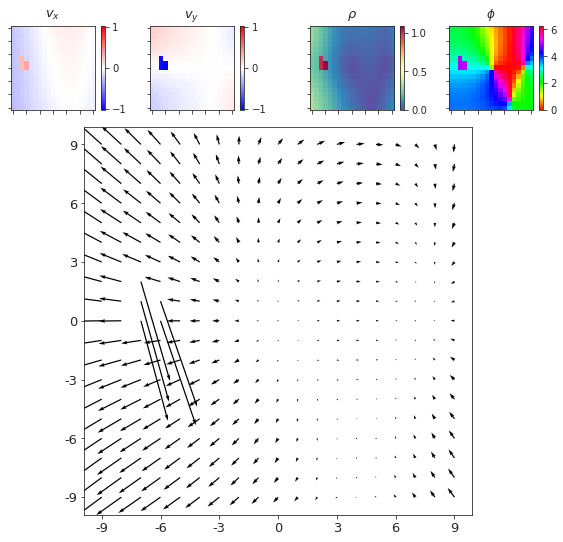

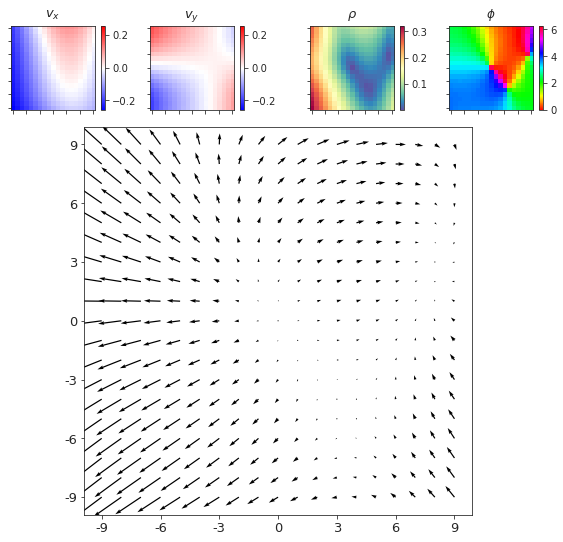

In [55]:
i = 71
show_opticflow_full(x[i])
show_opticflow_full(y[i]);

In [56]:
epe = endpoint_error(x, y)
epe_bal = epe * w / w.mean()
epe_bal = to_np(epe_bal)
np.argmax(epe_bal)

204

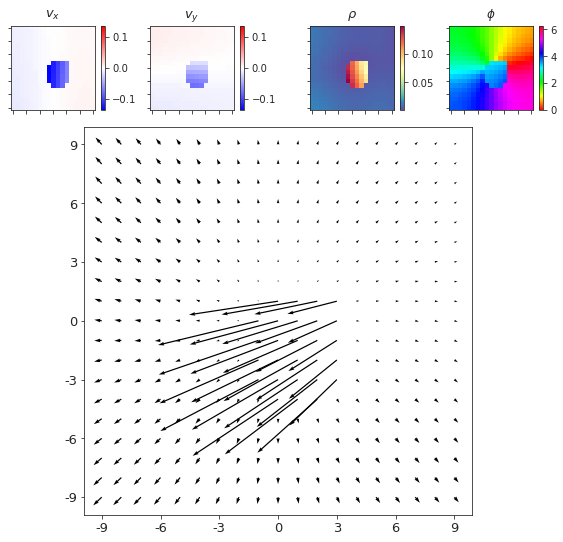

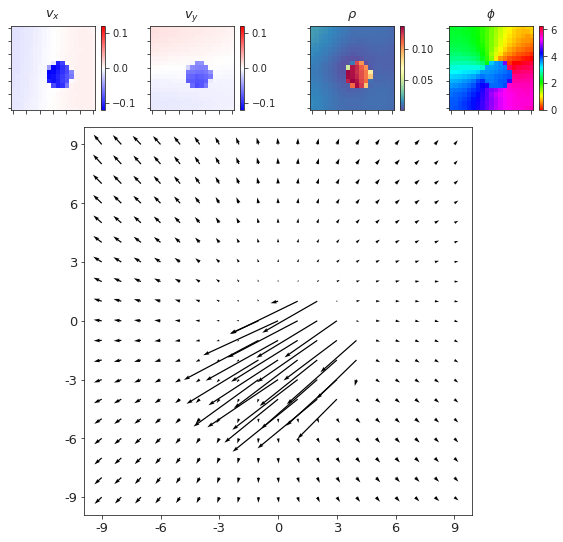

In [57]:
i = 204
show_opticflow_full(x[i])
show_opticflow_full(y[i]);

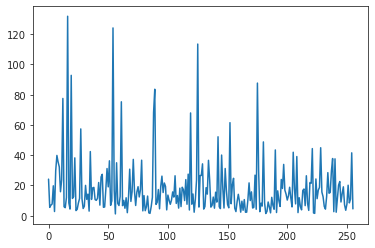

In [58]:
cos = 1 - tr.model.cos_recon(x, y)
cos = torch.sum(cos, dim=[1, 2])
cos = to_np(cos)
plt.plot(cos);

In [59]:
np.argmax(cos)

16

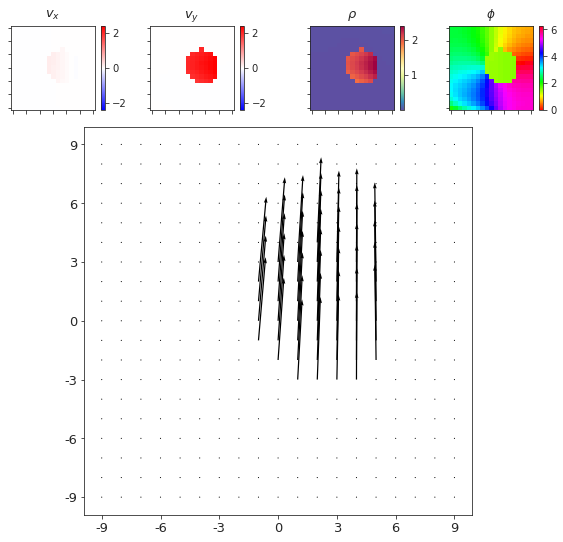

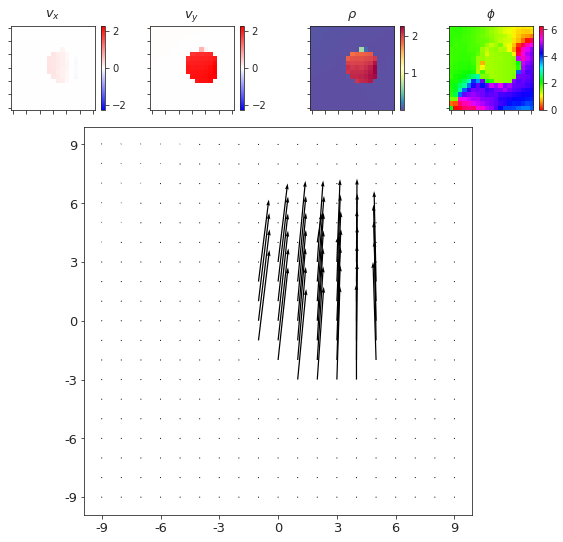

In [60]:
i = 16
show_opticflow_full(x[i])
show_opticflow_full(y[i]);

In [61]:
l2_true = vae.l2_recon(x, y)
l2_true = torch.sum(l2_true, dim=[1, 2, 3])
l2_true = l2_true * w / w.mean()
l2_true = to_np(l2_true)
l2_true.sum()

395.2473

In [62]:
l1_bal.sum(), l2_true.sum(), epe_bal.sum(), cos.sum()

(876.747, 395.2473, 1995.8989, 4570.678)

In [64]:
np.argsort(epe_bal)[:5]

array([ 66, 222, 185,  84,  87])

In [65]:
epe_bal[66], epe[66]

(3.0489206, tensor(5.2588, device='cuda:2'))

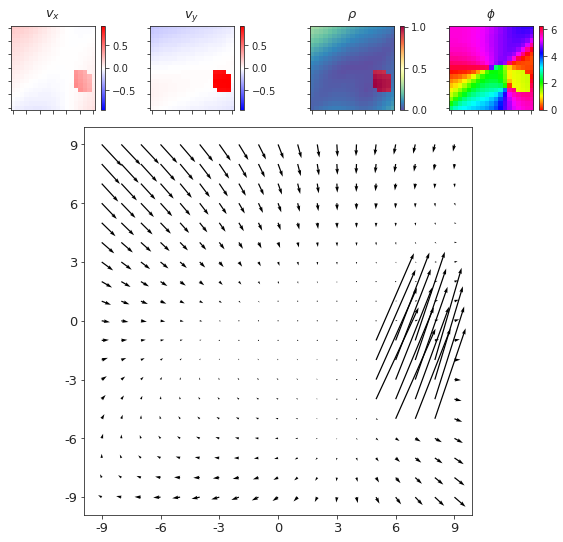

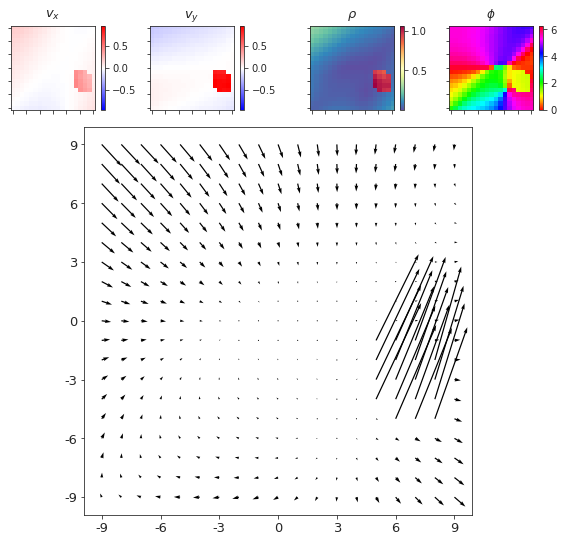

In [68]:
i = 185
show_opticflow_full(x[i])
show_opticflow_full(y[i]);

In [69]:
np.argsort(epe_bal)[-2]

216

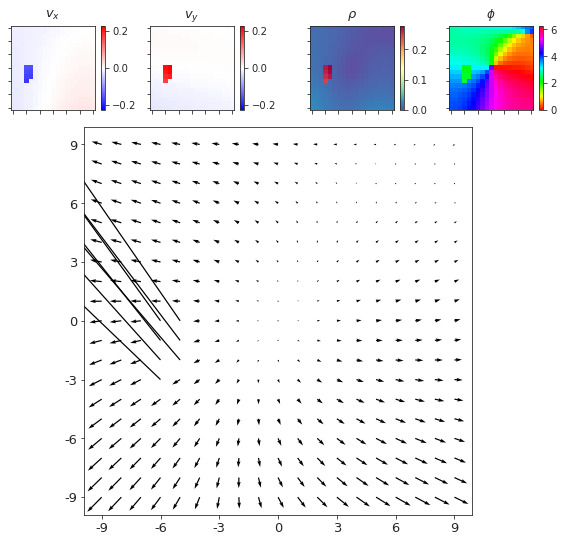

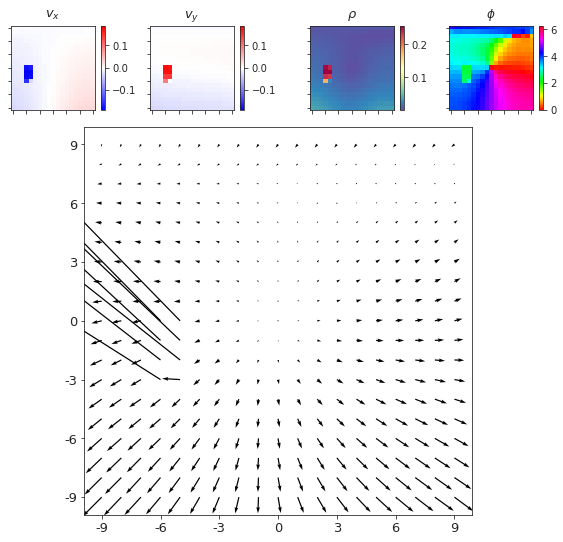

In [70]:
i = 216
show_opticflow_full(x[i])
show_opticflow_full(y[i]);

In [71]:
np.argmin(cos)

56

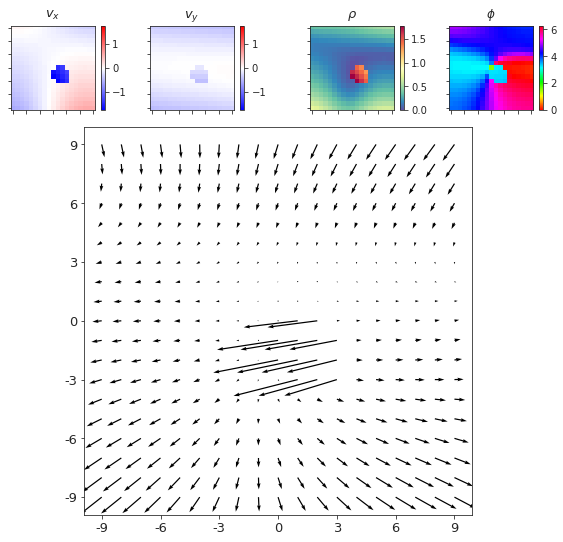

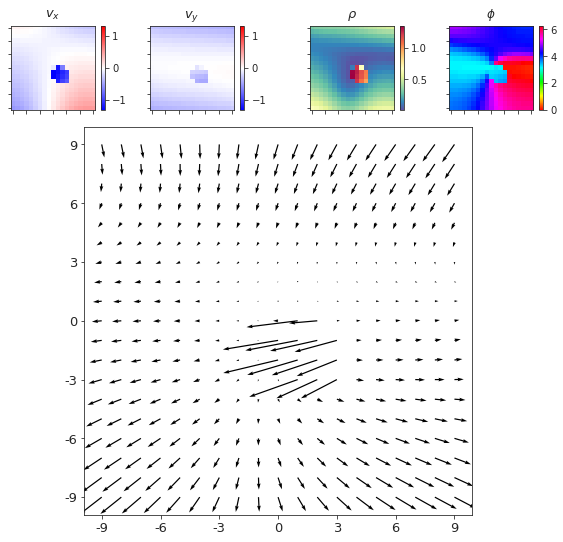

In [72]:
i = 56
show_opticflow_full(x[i])
show_opticflow_full(y[i]);

In [75]:
w2p = {}
norms_expand = {}
for i, layer in enumerate(vae.expand):
    w2p[i] = to_np(layer.weight)
    _norm = to_np(torch.linalg.norm(layer.weight, dim=1).sum())
    norms_expand[i] = _norm
print({i: np.round(v, 3) for i, v in norms_expand.items()})

{0: 84.471, 1: 217.295, 2: 652.654, 3: 302.024, 4: 1129.283, 5: 1069.541, 6: 576.633}

In [80]:
for i, _w in w2p.items():
    _w

In [81]:
_w.shape

(50, 50, 16, 16)

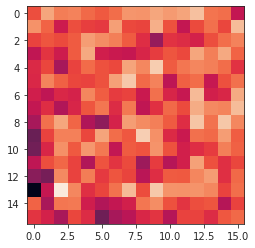

In [119]:
plt.imshow(_w[9, 26])

In [121]:
vae.cfg.n_latent_per_group

50

In [78]:
fig, axes = create_figure(num, num, (130, 90), 'all', 'all')
for z, k in itertools.product(range(num), range(num)):
    ax = axes[z, k]
    im = ax.imshow(_w[z, k])
    plt.colorbar(im, ax=ax)
    if z == 0:
        ax.set_title(f"k = {k}", fontsize=13)
    if k == 0:
        ax.set_ylabel(f"z = {z}", fontsize=13)
fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
plt.show()

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f7173bef8b0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f7173c08940> (for post_execute):


KeyboardInterrupt: 

In [76]:
scales, _ = tr.model.latent_scales()
num = vae.cfg.n_latent_per_group

for i, _w in w2p.items():
    fig, axes = create_figure(num, num, (50, 30), 'all', 'all', tight_layout=True)
    for z, k in itertools.product(range(num), range(num)):
        ax = axes[z, k]
        im = ax.imshow(_w[z, k])
        plt.colorbar(im, ax=ax)
        if z == 0:
            ax.set_title(f"k = {k}", fontsize=13)
        if k == 0:
            ax.set_ylabel(f"z = {z}", fontsize=13)
    fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
    plt.show()

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f7173bef8b0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f7173c08940> (for post_execute):


KeyboardInterrupt: 

In [13]:
from model.vae2d import *

In [14]:
norms = collections.defaultdict(list)
# norms['stem'] = list(to_np(vae.stem.log_weight_norm.exp()))
for cell in vae.enc_tower:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms[f"{type(cell).__name__}_enc"].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.dec_tower:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms[f"{type(cell).__name__}_dec"].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.enc_sampler:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms['enc_sampler'].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.dec_sampler:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms['dec_sampler'].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.expand:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms['expand'].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.post:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms[f"{type(cell).__name__}_post"].extend(
                list(to_np(m.log_weight_norm.exp())))
norms = dict(sorted(norms.items()))

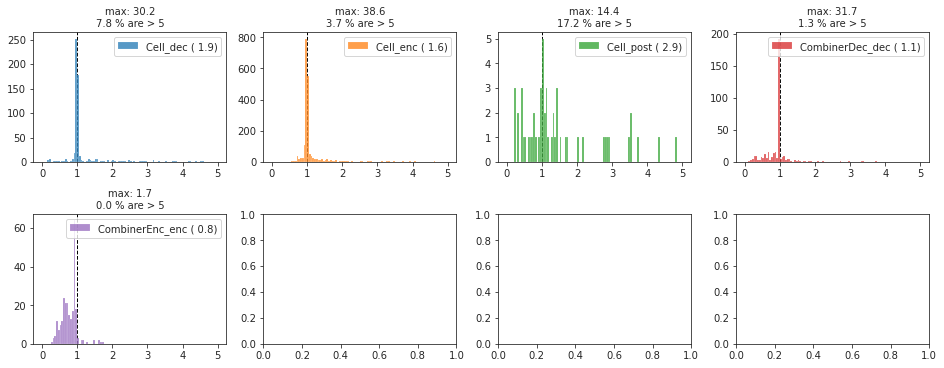

In [15]:
fig, axes = create_figure(2, 4, (13, 5), constrained_layout=True)
for i, (k, v) in enumerate(norms.items()):
    ax = axes.flat[i]
    ax.axvline(1, color='k', ls='--', lw=1.0, zorder=0)
    sns.histplot(v, color=f"C{i}", bins=np.linspace(0, 5, 101), label=f"{k} ({np.mean(v): 0.1f})", ax=ax)
    title = f"max: {np.max(v):0.1f}\n{100 * (np.array(v) > 5).sum() / len(v):0.1f} % are > 5"
    ax.set_title(title, fontsize=10)
    ax.set_ylabel('')
    ax.legend()
plt.show()

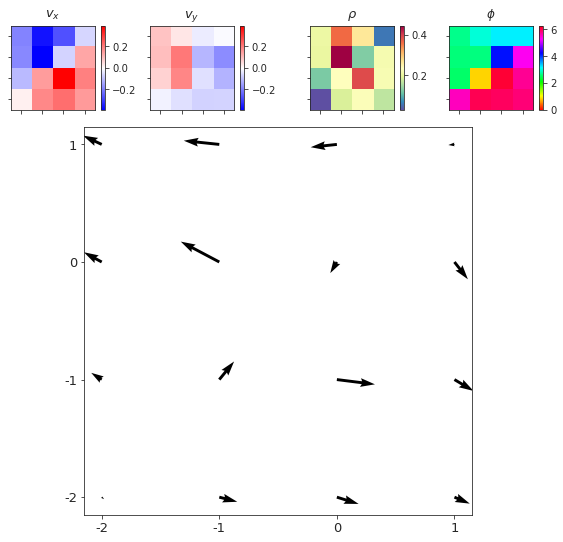

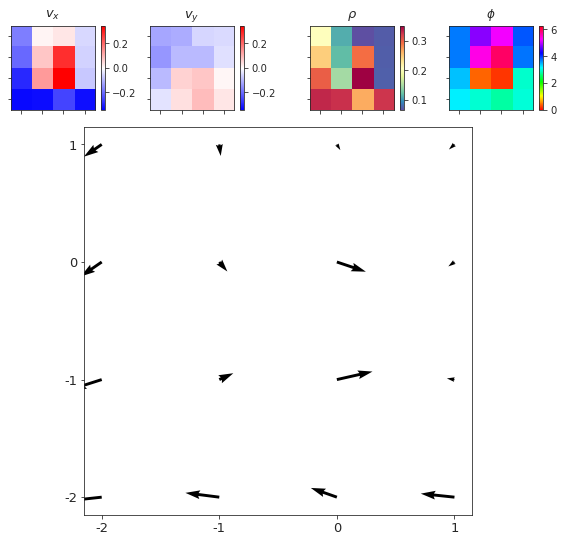

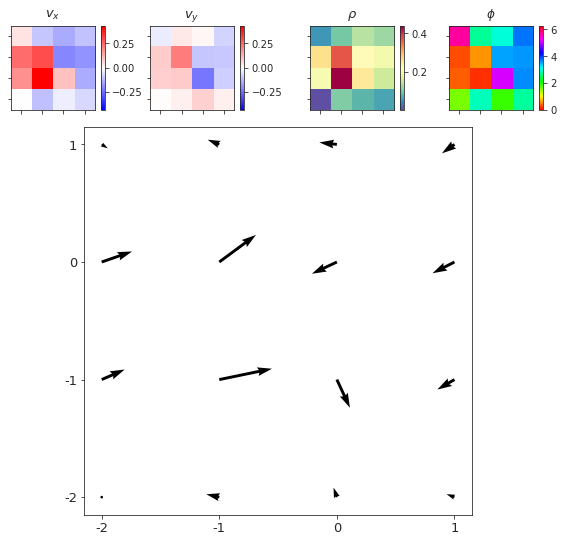

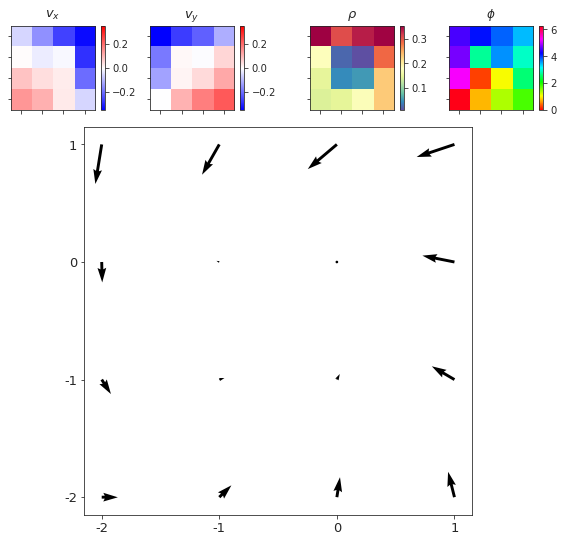

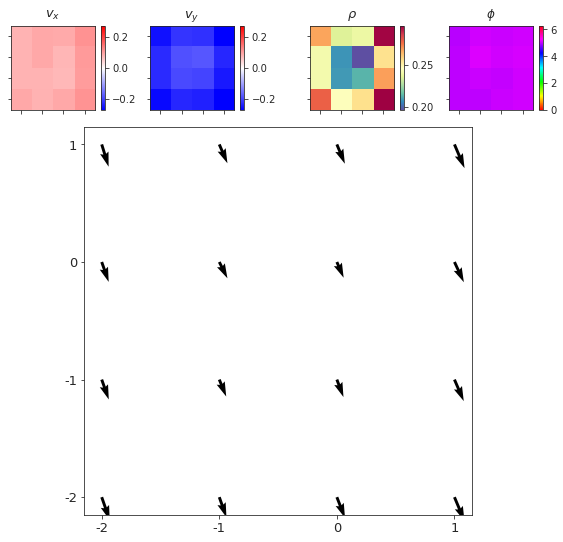

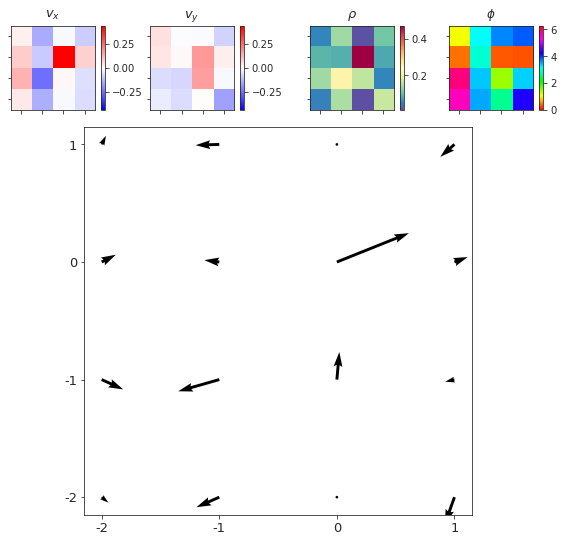

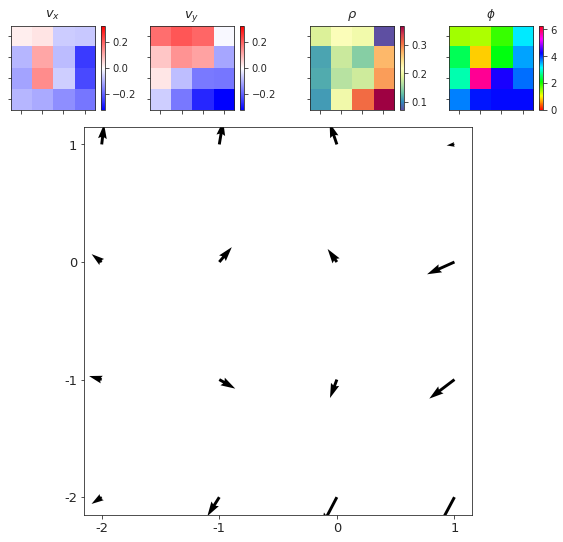

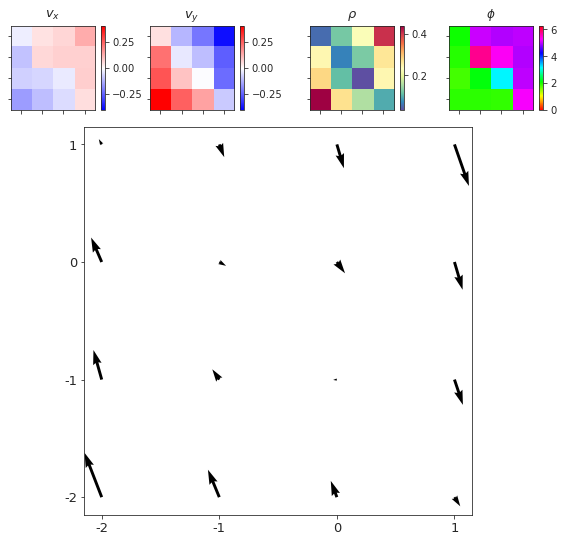

In [26]:
for k in range(len(w)):
    _ = show_opticflow_full(w[k], tick_spacing=1)

In [27]:
vae.stem

ParametrizedRotConv2d(
  2, 8, kernel_size=(4, 4), stride=(1, 1), padding=valid
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): _SpectralNorm()
    )
  )
)

In [28]:
w2p = {}
norms_expand = {}
for i, layer in enumerate(vae.expand):
    w2p[i] = to_np(layer.weight)
    _norm = to_np(layer.log_weight_norm.exp())
    norms_expand[i] = list(_norm)

In [29]:
print({i: np.round(v, 3) for i, v in norms_expand.items()})

{
    0: array([8.042], dtype=float32),
    1: array([9.718], dtype=float32),
    2: array([24.953], dtype=float32),
    3: array([175.119], dtype=float32),
    4: array([279.539], dtype=float32),
    5: array([63.6], dtype=float32),
    6: array([35.539], dtype=float32)
}

In [30]:
w2p[0].shape

(4, 1, 4, 4)

In [31]:
scales = vae.latent_scales()

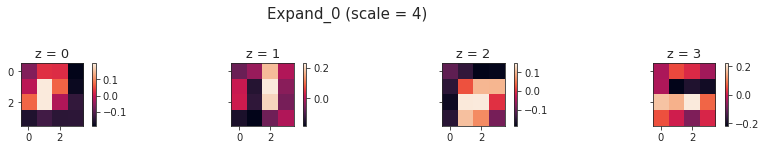

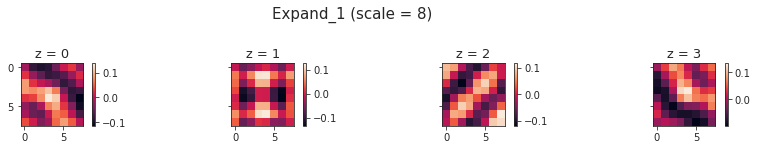

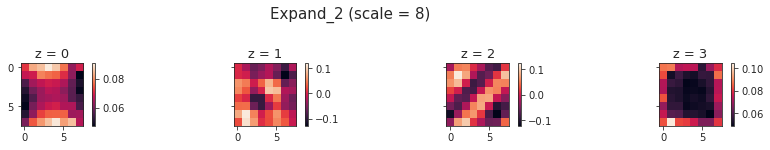

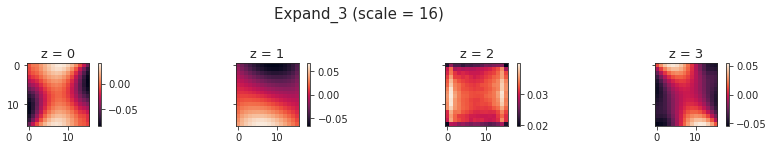

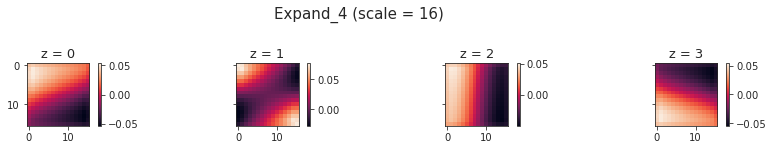

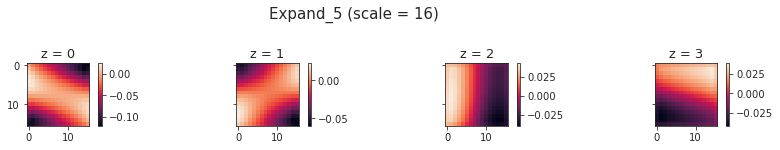

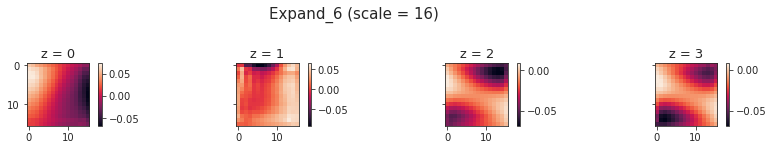

In [32]:
for i, _w in w2p.items():
    num = tr.model.cfg.n_latent_per_group
    fig, axes = create_figure(1, num, (12, 2.0), 'all', 'all', tight_layout=True)
    for z in range(num):
        ax = axes.flat[z]
        im = ax.imshow(_w[z, 0])
        plt.colorbar(im, ax=ax)
        ax.set_title(f'z = {z}', fontsize=13)
    fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
    plt.show()

In [33]:
x_sample, z_sample = val['x_sample'], val['z_sample']

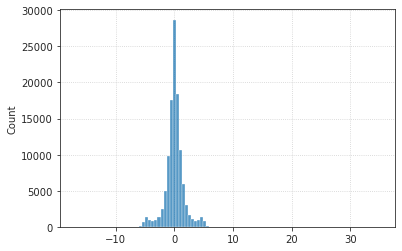

In [34]:
ax = sns.histplot(z_sample.ravel(), bins=100)
ax.grid()

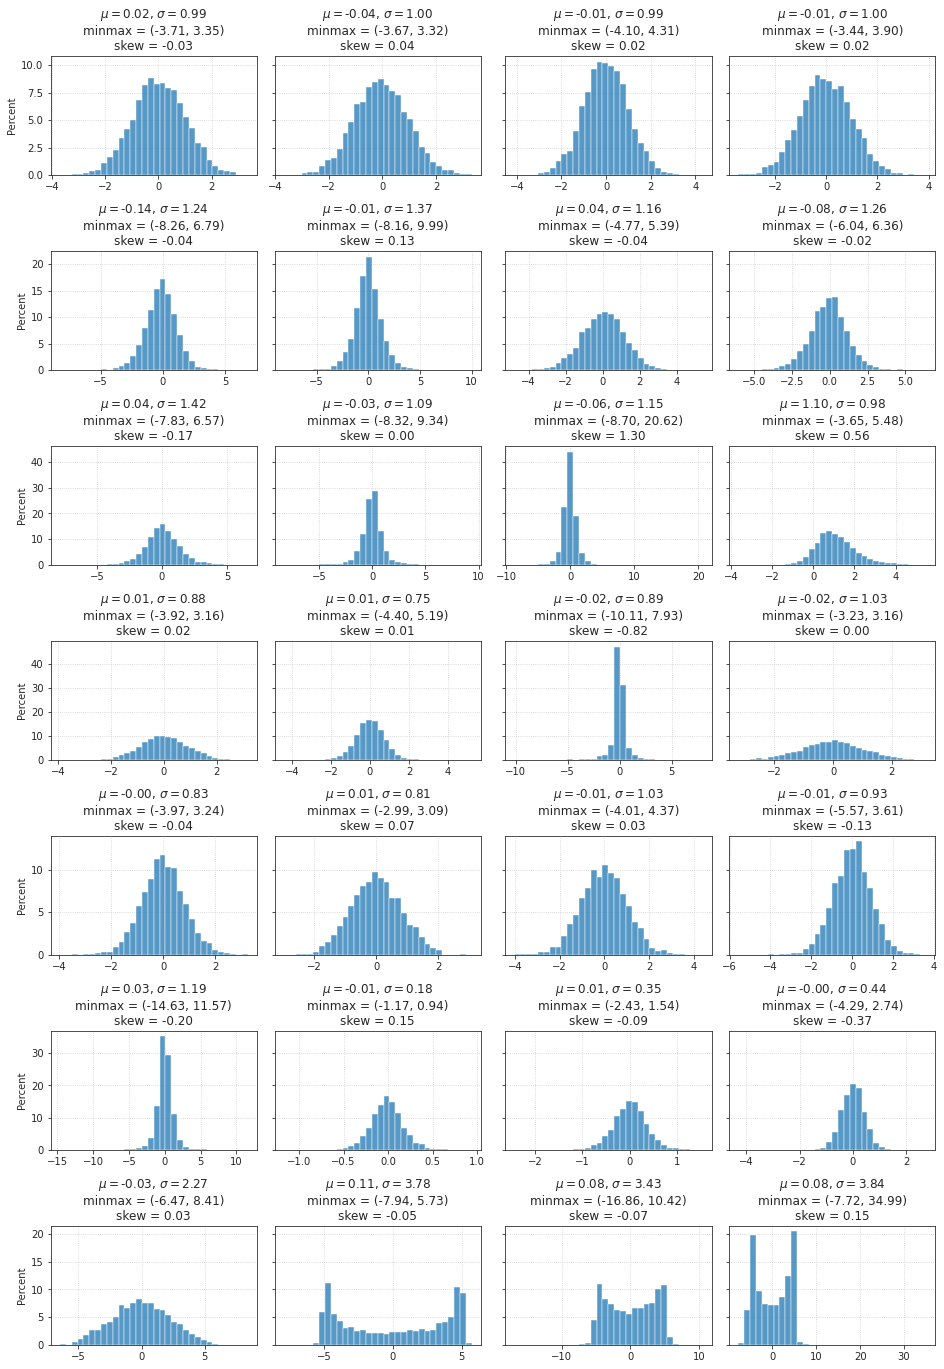

In [37]:
_ = plot_latents_hist_full(z_sample, scales)

In [38]:
rho, theta = vel2polar(np.transpose(x_sample, (0, 2, 3, 1)))
rho.shape

(4096, 19, 19)

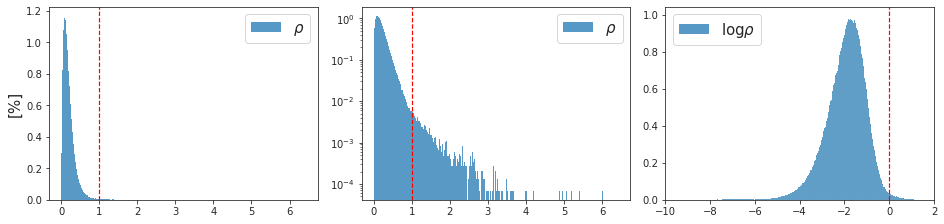

In [39]:
fig, axes = create_figure(1, 3, (13, 3), constrained_layout=True)
sns.histplot(rho.ravel(), stat='percent', label=r'$\rho$', ax=axes[0])
sns.histplot(rho.ravel(), stat='percent', label=r'$\rho$', ax=axes[1])
sns.histplot(np.log(rho[rho.nonzero()]), label=r'$\log \rho$', stat='percent', ax=axes[2])

for ax in axes.flat:
    ax.set_ylabel('')
    ax.legend(fontsize=15)
for ax in axes[:2].flat:
    ax.axvline(1, color='r', ls='--', lw=1.2)

axes[0].set_ylabel('[%]', fontsize=15)
axes[1].set_yscale('log')
axes[2].set_xlim(-10, 2)
axes[2].axvline(0, color='r', ls='--', lw=1.2)

plt.show()

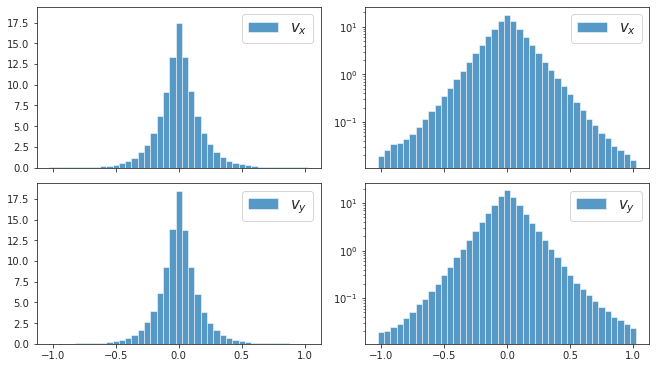

In [40]:
n = 40
bins = np.linspace(-1, 1 + 2 / n, n + 2) - 1 / n

fig, axes = create_figure(2, 2, figsize=(9, 5), sharex='all', sharey='col', constrained_layout=True)
for i in range(2):
    lbl = r'$v_x$' if i == 0 else r'$v_y$'
    sns.histplot(x_sample[:, i, ...].ravel(), label=lbl, bins=bins, stat='percent', ax=axes[i, 0])
    sns.histplot(x_sample[:, i, ...].ravel(), label=lbl, bins=bins, stat='percent', ax=axes[i, 1])
    axes[i, 1].set_yscale('log')
for ax in axes.flat:
    ax.set_ylabel('')
    ax.legend(fontsize=15)
plt.show()

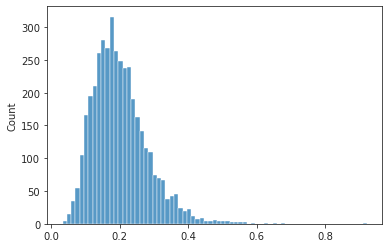

In [41]:
norm = rho.mean(1).mean(1)
sns.histplot(norm);

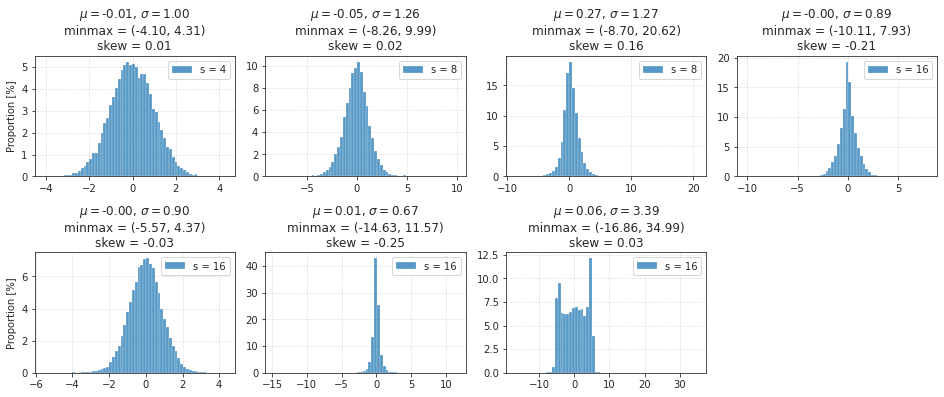

In [42]:
plot_latents_hist(z_sample, scales);

In [43]:
ticks = [
    i for i in range(tr.model.cfg.total_latents())
    if i % tr.model.cfg.n_latent_per_group == 0
]
ticklabels = [i + 1 for i in ticks]

In [44]:
val['z'].shape

(7500, 28)

In [45]:
u, s, v = sp_lin.svd(val['z'], full_matrices=False, compute_uv=True)
s *= 100 / s.sum()
u.shape, s.shape, v.shape

((7500, 28), (28,), (28, 28))

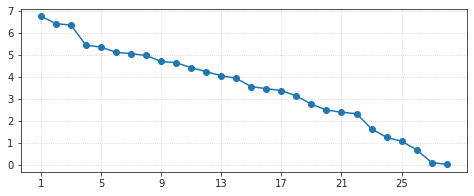

In [46]:
fig, ax = create_figure(figsize=(8, 3))
ax.plot(s, marker='o')
ax.set(xticks=ticks, xticklabels=ticklabels)
ax.grid()

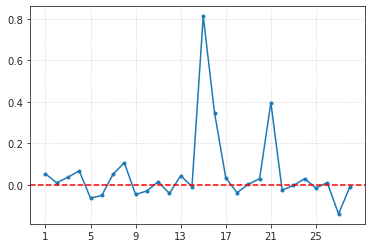

In [47]:
fig, ax = create_figure()
ax.plot(v[3], marker='.')
ax.axhline(0, color='r', ls='--')
ax.set(xticks=ticks, xticklabels=ticklabels)
ax.grid()
plt.show()

In [48]:
r = 1 - sp_dist.pdist(val['z'].T, 'correlation')
r = sp_dist.squareform(r)

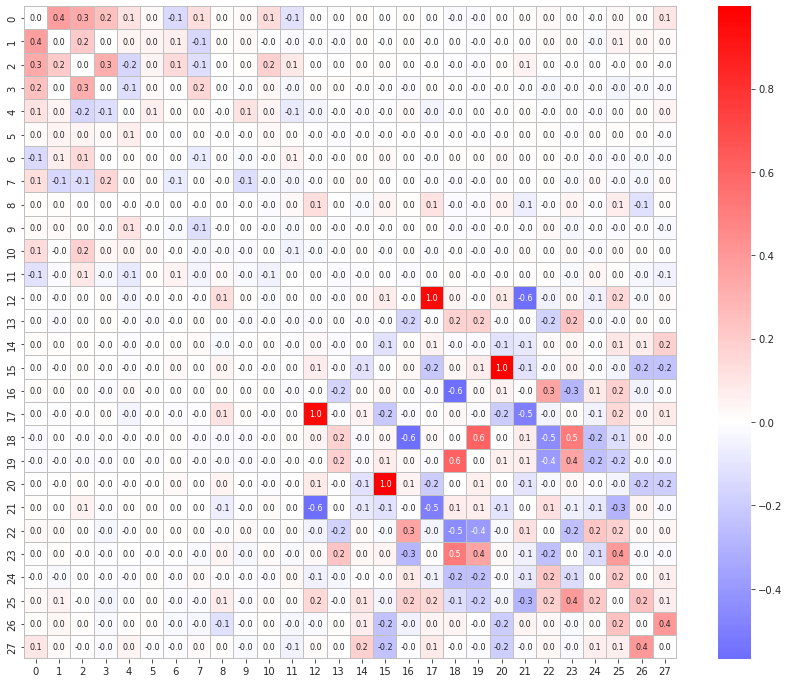

In [49]:
fig, ax = create_figure(1, 1, (15, 12))
sns.heatmap(
    r,
    center=0,
    cmap='bwr',
    linewidths=0.005,
    linecolor='silver',
    square=True,
    annot=True,
    fmt='.1f',
    annot_kws={'fontsize': 8},
    ax=ax,
);

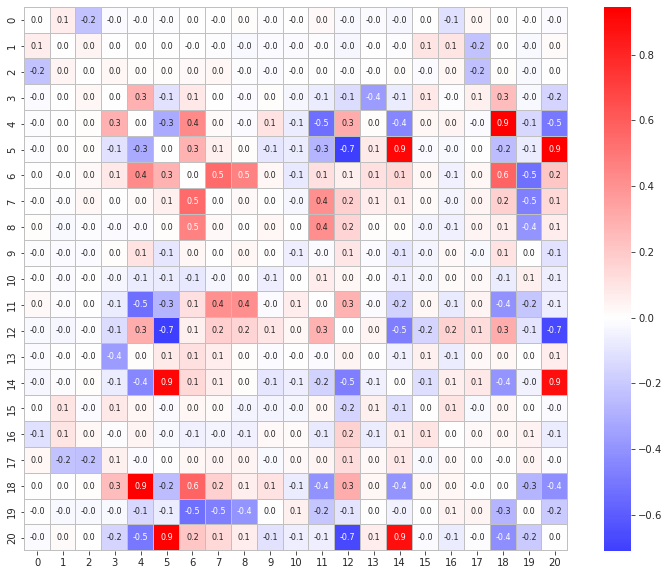

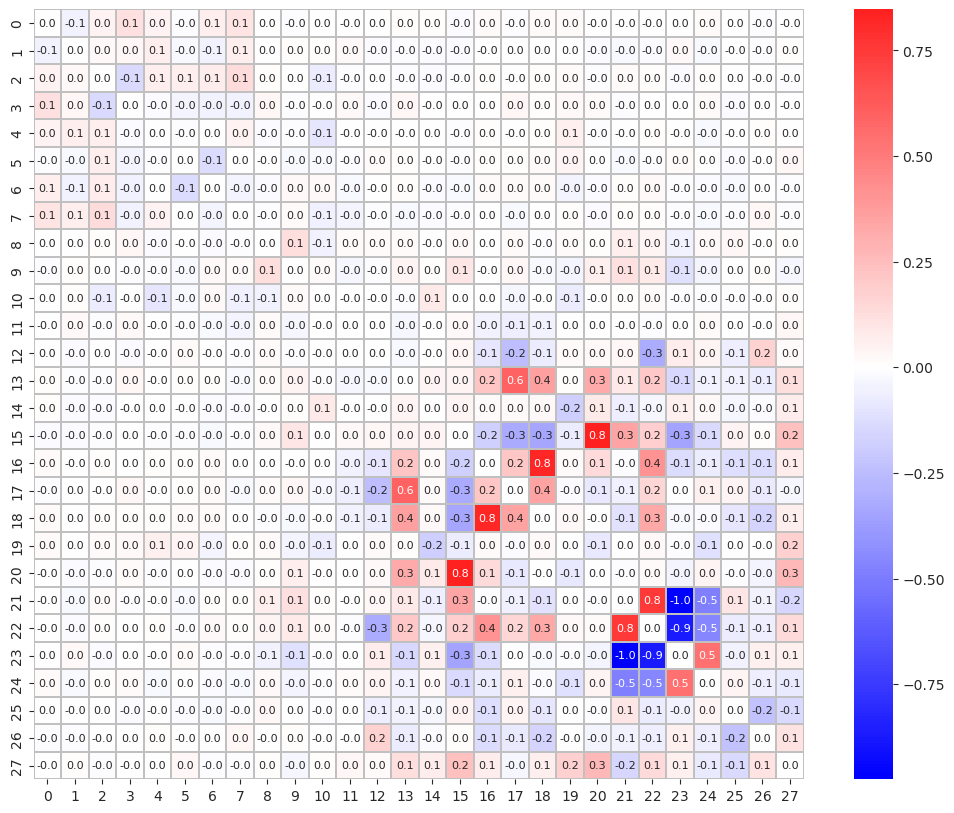

In [50]:
# create datasets
f = pjoin(tr.model.cfg.data_dir, tr.model.cfg.h_pre)
f = h5py.File(f, mode='r')
fix = np.array(f['vld']['fix'], dtype=float)
pos_obj = np.array(f['vld']['pos_obj'], dtype=float)
vel_obj = np.array(f['vld']['vel_obj'], dtype=float)
vel_slf = np.array(f['vld']['vel_slf'], dtype=float)
f.close()

In [51]:
pos = dc(pos_obj)
pos[0] -= fix[:, 0]
pos[1] -= fix[:, 1]

In [52]:
g = np_nans((len(fix), 11))
g[:, :2] = fix
g[:, 2:5] = vel_slf.T
g[:, 5:8] = vel_obj.T
g[:, 8:11] = pos.T
g.shape

(7500, 11)

In [53]:
u_g, s_g, v_g = sp_lin.svd(g, full_matrices=False, compute_uv=True)
s_g *= 100 / s_g.sum()
u_g.shape, s_g.shape, v_g.shape

((7500, 11), (11,), (11, 11))

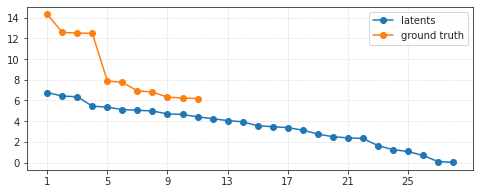

In [54]:
fig, ax = create_figure(figsize=(8, 3))
ax.plot(s, marker='o', label='latents')
ax.plot(s_g, marker='o', label='ground truth')
ax.set(xticks=ticks, xticklabels=ticklabels)
ax.legend()
ax.grid()

In [57]:
rho, theta = vel2polar(val['x_sample'])

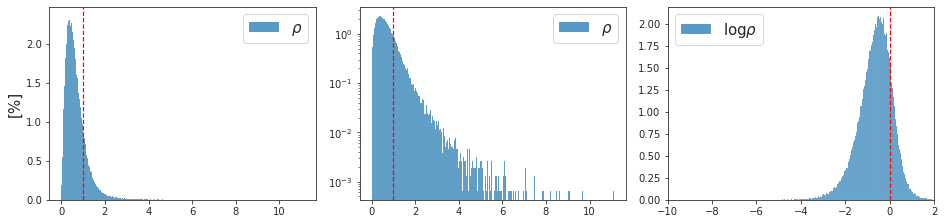

In [58]:
fig, axes = create_figure(1, 3, (13, 3), constrained_layout=True)
sns.histplot(rho.ravel(), stat='percent', label=r'$\rho$', ax=axes[0])
sns.histplot(rho.ravel(), stat='percent', label=r'$\rho$', ax=axes[1])
sns.histplot(np.log(rho[rho.nonzero()]), label=r'$\log \rho$', stat='percent', ax=axes[2])

for ax in axes.flat:
    ax.set_ylabel('')
    ax.legend(fontsize=15)
for ax in axes[:2].flat:
    ax.axvline(1, color='r', ls='--', lw=1.2)

axes[0].set_ylabel('[%]', fontsize=15)
axes[1].set_yscale('log')
axes[2].set_xlim(-10, 2)
axes[2].axvline(0, color='r', ls='--', lw=1.2)

plt.show()

In [59]:
num = 20
z_vld = np_nans((num, len(tr.dl_vld.dataset), tr.model.cfg.total_latents()))
z_tst = np_nans((num, len(tr.dl_tst.dataset), tr.model.cfg.total_latents()))

for i in tqdm(range(num)):
    z_vld[i] = tr.forward('vld', False)[0]['z']
    z_tst[i] = tr.forward('tst', False)[0]['z']

100%|██████████| 20/20 [01:39<00:00,  4.97s/it]


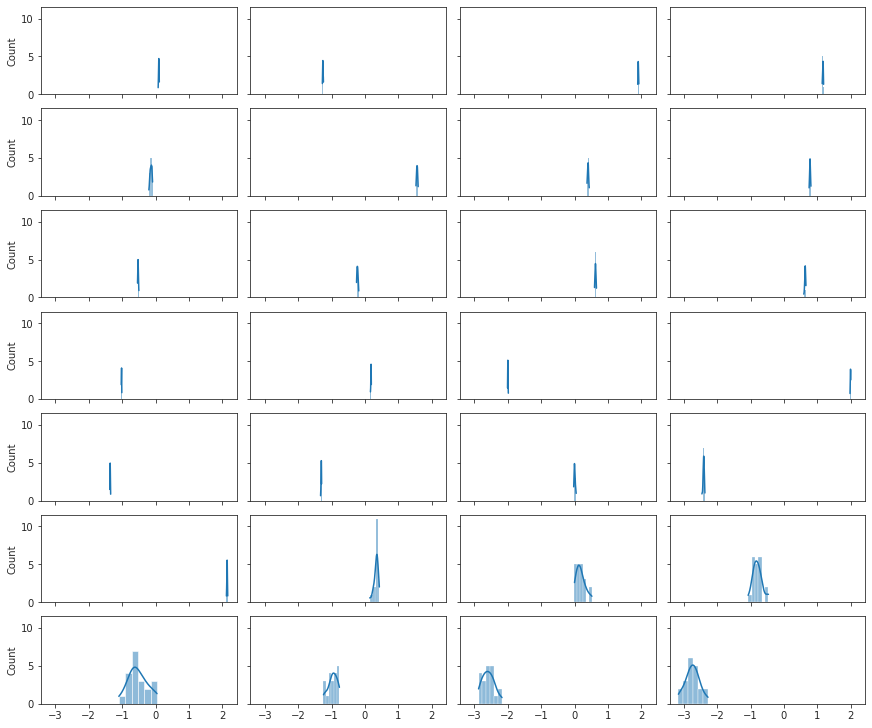

In [61]:
fig, axes = create_figure(
    7, tr.model.cfg.n_latent_per_group, (12, 10), 'all', 'all', constrained_layout=True)
for i, ax in enumerate(axes.flat):
    sns.histplot(z_vld[:, 500, i], kde=True, ax=ax)

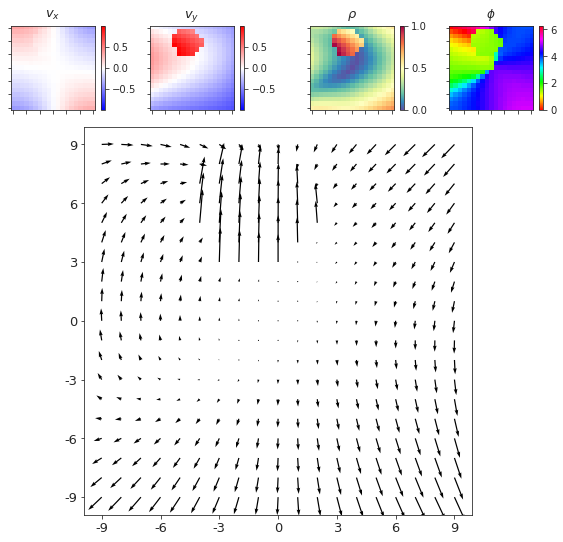

In [79]:
show_opticflow_full(val['x'][500]);

In [62]:
r = 1 - sp_dist.pdist(z_vld.mean(0).T, 'correlation')
r = sp_dist.squareform(r)

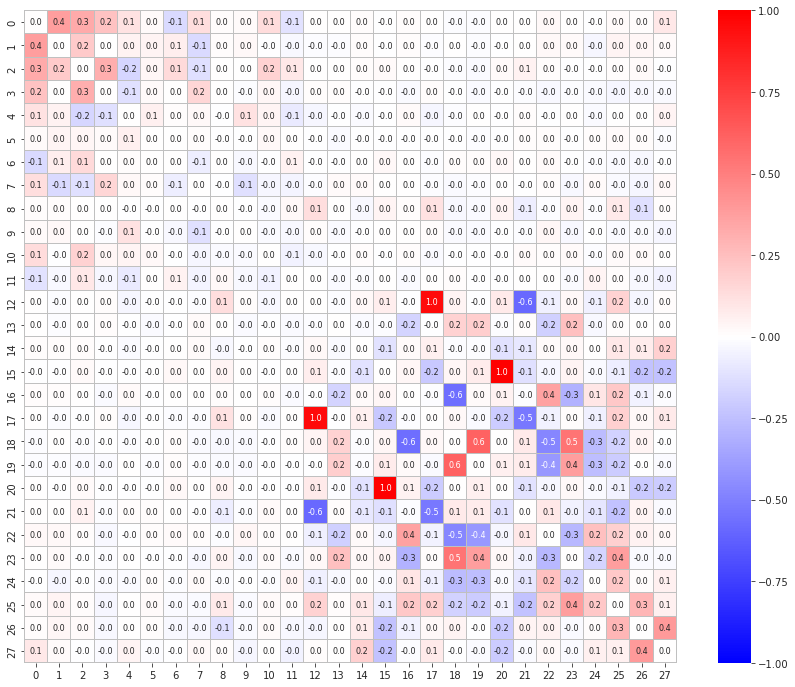

In [63]:
fig, ax = create_figure(1, 1, (15, 12))
sns.heatmap(
    r,
    vmin=-1,
    vmax=1,
    cmap='bwr',
    linewidths=0.005,
    linecolor='silver',
    square=True,
    annot=True,
    fmt='.1f',
    annot_kws={'fontsize': 8},
    ax=ax,
);

In [64]:
# create datasets
f = pjoin(tr.model.cfg.data_dir, tr.model.cfg.h_pre)
f = h5py.File(f, mode='r')
fix_vld = np.array(f['vld']['fix'], dtype=float)
pos_obj_vld = np.array(f['vld']['pos_obj'], dtype=float)
vel_obj_vld = np.array(f['vld']['vel_obj'], dtype=float)
vel_slf_vld = np.array(f['vld']['vel_slf'], dtype=float)
f.close()

pos_vld = dc(pos_obj_vld)
pos_vld[0] -= fix_vld[:, 0]
pos_vld[1] -= fix_vld[:, 1]
g_vld = np_nans((len(fix_vld), 11))
g_vld[:, :2] = fix_vld
g_vld[:, 2:5] = vel_slf_vld.T
g_vld[:, 5:8] = vel_obj_vld.T
g_vld[:, 8:11] = pos_vld.T
g_vld.shape

(7500, 11)

In [65]:
# create datasets
f = pjoin(tr.model.cfg.data_dir, tr.model.cfg.h_pre)
f = h5py.File(f, mode='r')
fix_tst = np.array(f['tst']['fix'], dtype=float)
pos_obj_tst = np.array(f['tst']['pos_obj'], dtype=float)
vel_obj_tst = np.array(f['tst']['vel_obj'], dtype=float)
vel_slf_tst = np.array(f['tst']['vel_slf'], dtype=float)
f.close()

pos_tst = dc(pos_obj_tst)
pos_tst[0] -= fix_tst[:, 0]
pos_tst[1] -= fix_tst[:, 1]
g_tst = np_nans((len(fix_tst), 11))
g_tst[:, :2] = fix_tst
g_tst[:, 2:5] = vel_slf_tst.T
g_tst[:, 5:8] = vel_obj_tst.T
g_tst[:, 8:11] = pos_tst.T
g_tst.shape

(2500, 11)

In [66]:
dim_names = {
    0: 'fix_x',
    1: 'fix_y',
    
    2: 'v_self_x',
    3: 'v_self_y',
    4: 'v_self_z',
    
    5: 'v_obj_x',
    6: 'v_obj_y',
    7: 'v_obj_z',
    
    8: 'pos_obj_x',
    9: 'pos_obj_y',
    10: 'pos_obj_z',
}

In [67]:
corr = 1 - sp_dist.pdist(g_vld.T, metric='correlation')
corr = sp_dist.squareform(corr)
corr.shape

(11, 11)

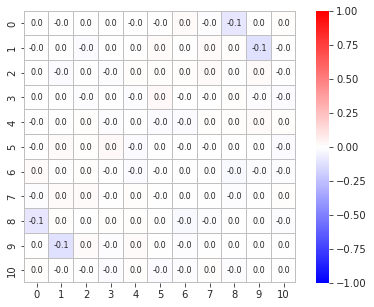

In [68]:
fig, ax = create_figure(1, 1, (7, 5))
sns.heatmap(
    corr,
    center=0,
    cmap='bwr',
    vmin=-1,
    vmax=1,
    linewidths=0.005,
    linecolor='silver',
    square=True,
    annot=True,
    fmt='.1f',
    annot_kws={'fontsize': 8},
    ax=ax,
);

In [69]:
u_g, s_g, v_g = sp_lin.svd(g_vld, full_matrices=False, compute_uv=True)
s_g *= 100 / s_g.sum()
u_g.shape, s_g.shape, v_g.shape

((7500, 11), (11,), (11, 11))

In [70]:
u, s, v = sp_lin.svd(z_vld.mean(0), full_matrices=False, compute_uv=True)
s *= 100 / s.sum()
u.shape, s.shape, v.shape

((7500, 28), (28,), (28, 28))

In [71]:
ticks = [
    i for i in range(tr.model.cfg.total_latents())
    if i % tr.model.cfg.n_latent_per_group == 0
]
ticklabels = [i + 1 for i in ticks]

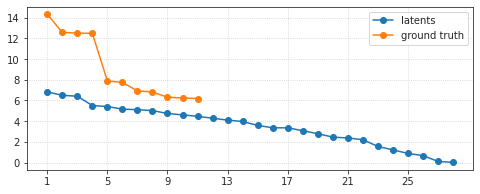

In [72]:
fig, ax = create_figure(figsize=(8, 3))
ax.plot(s, marker='o', label='latents')
ax.plot(s_g, marker='o', label='ground truth')
ax.set(xticks=ticks, xticklabels=ticklabels)
ax.legend()
ax.grid()

In [73]:
from sklearn import linear_model

In [74]:
lr = linear_model.LinearRegression().fit(z_vld.mean(0), g_vld)
pred = lr.predict(z_tst.mean(0))
r = 1 - sp_dist.cdist(pred.T, g_tst.T, metric='correlation')
pred.shape, r.shape

((2500, 11), (11, 11))

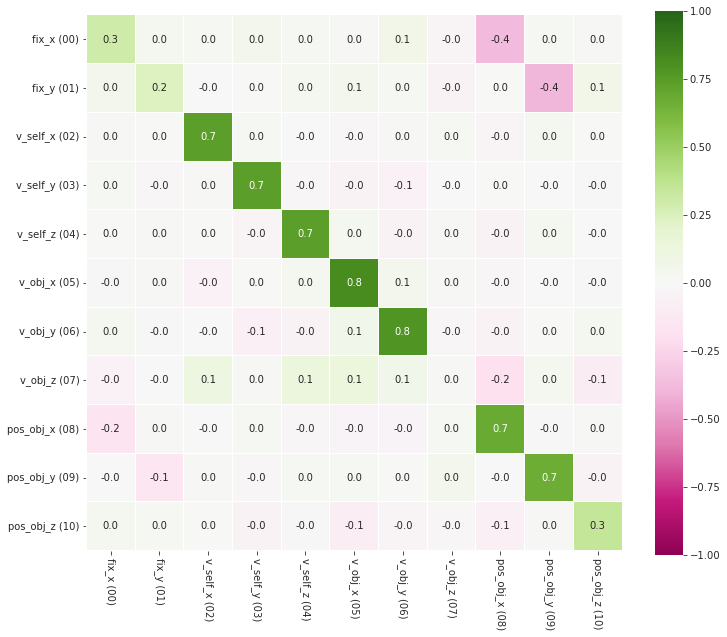

In [75]:
fig, ax = create_figure(figsize=(12, 10))
sns.heatmap(
    r,
    cmap='PiYG',
    vmin=-1, 
    vmax=1,
    square=True,
    linewidth=0.01,
    annot=True,
    fmt='.1f',
    annot_kws={'fontsize': 10},
    ax=ax
)
_t = [f"{e} ({i:02d})" for i, e in dim_names.items()]
ax.set(xticklabels=_t, yticklabels=_t)
ax.tick_params(axis='x', rotation=-90)
ax.tick_params(axis='y', rotation=0)
plt.show()

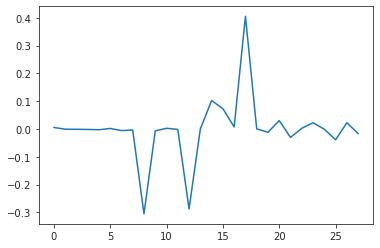

In [76]:
plt.plot(lr.coef_[5])

In [77]:
lr = linear_model.LinearRegression().fit(g_vld, z_vld.mean(0))
pred = lr.predict(g_tst)
r = 1 - sp_dist.cdist(pred.T, z_tst.mean(0).T, metric='correlation')
pred.shape, r.shape

((2500, 28), (28, 28))

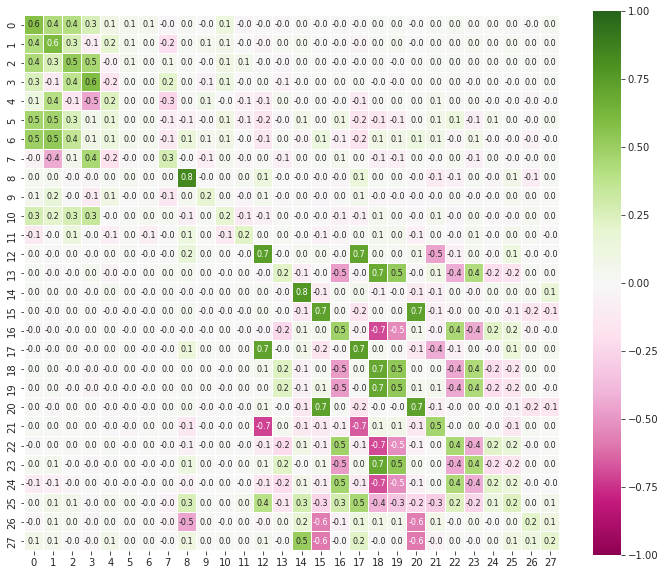

In [78]:
fig, ax = create_figure(figsize=(12, 10))
sns.heatmap(
    r,
    cmap='PiYG',
    vmin=-1, 
    vmax=1,
    square=True,
    linewidth=0.01,
    annot=True,
    fmt='.1f',
    annot_kws={'fontsize': 8},
    ax=ax
)
plt.show()

In [79]:
from sklearn.feature_selection import mutual_info_regression

In [81]:
mi = np.zeros((11, tr.model.cfg.total_latents()))
for i in range(11):
    mi[i] = mutual_info_regression(z_vld.mean(0), g_vld[:, i])

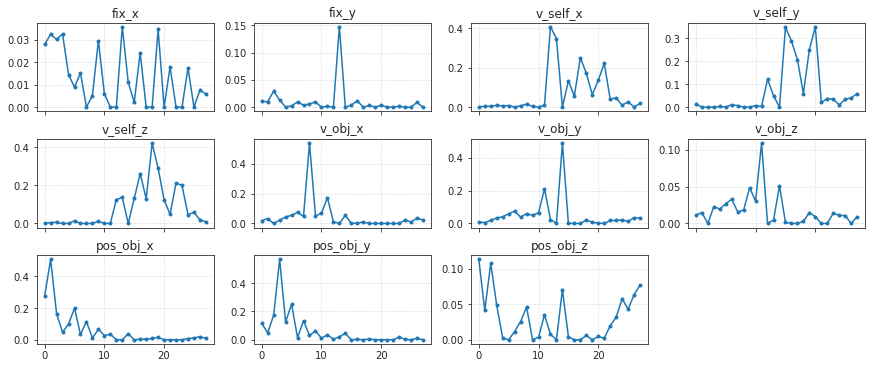

In [82]:
fig, axes = create_figure(3, 4, (12, 5), 'all', 'none', constrained_layout=True)
for i in range(11):
    ax = axes.flat[i]
    ax.plot(mi[i], marker='.')
    ax.set_title(dim_names[i])
    ax.grid()
trim_axs(axes, 11)
plt.show()

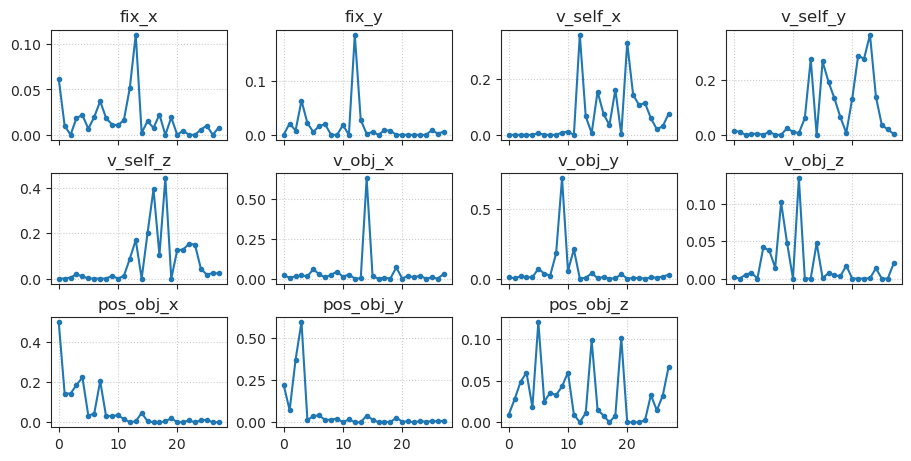

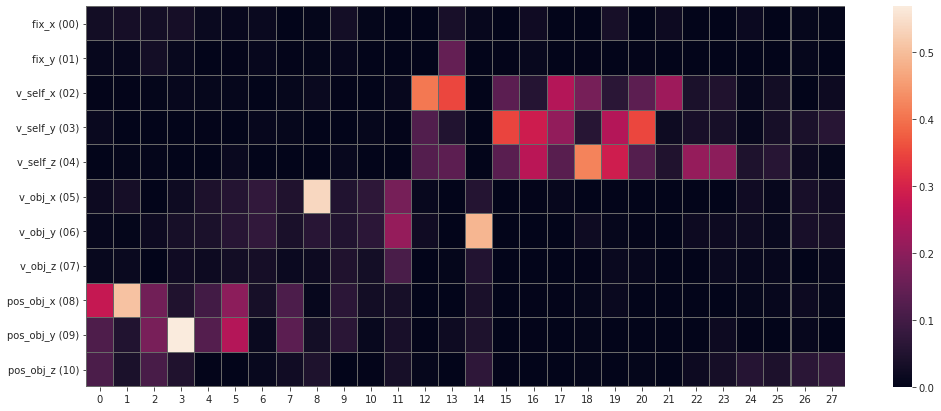

In [83]:
fig, ax = create_figure(figsize=(17, 7))
sns.heatmap(mi, vmin=0, linewidth=0.01, linecolor='dimgrey')
ax.set_yticklabels([f"{e} ({i:02d})" for i, e in dim_names.items()])
ax.tick_params(axis='y', rotation=0)
plt.show()

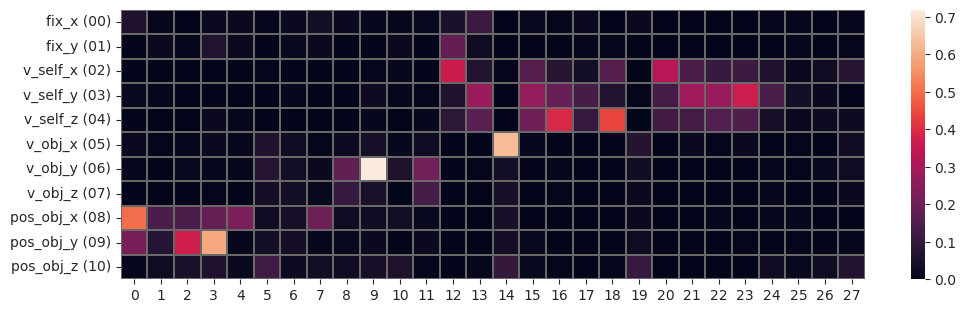

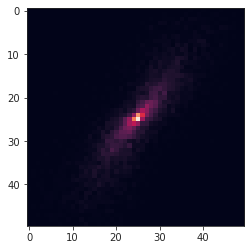

In [135]:
i, j = 6, 9
c_xy = np.histogram2d(g_vld[:, i], z_vld.mean(0)[:, j], 50)[0]
plt.imshow(c_xy);

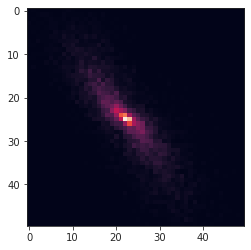

In [137]:
i, j = 5, 10
c_xy = np.histogram2d(g_vld[:, i], z_vld.mean(0)[:, j], 50)[0]
plt.imshow(c_xy);

In [138]:
fix = g_vld[:, :2]
fix = np.concatenate([
    fix,
    np.ones((len(fix), 1)),
], axis=1)
fix.shape

(7500, 3)

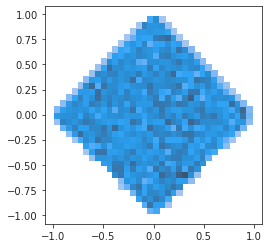

In [139]:
ax = sns.histplot(x=fix[:, 0], y=fix[:, 1])
ax_square(ax);

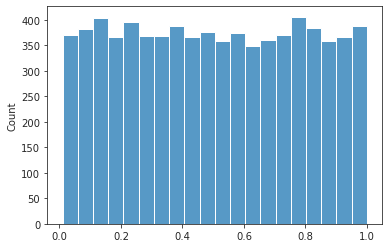

In [141]:
heading = g_vld[:, 2:5]
sns.histplot(cart2polar(heading)[:, 0]);

In [144]:
fix.shape, heading.shape

((7500, 3), (7500, 3))

In [145]:
cos = 1 - sp_dist.cdist(fix, heading, metric='cosine')
theta = np.arccos(np.diag(cos))
theta.shape

(7500,)

In [146]:
mi_emerg = mutual_info_regression(z_vld.mean(0), theta)
mi_emerg.shape

(21,)

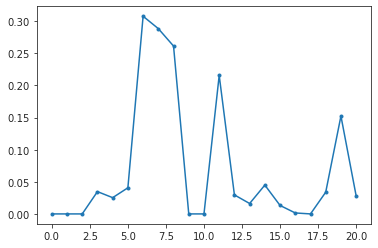

In [147]:
plt.plot(mi_emerg, marker='.')

In [161]:
sp_stats.pearsonr(z_vld.mean(0)[:, 6], theta)

(-0.6325539907609852, 0.0)

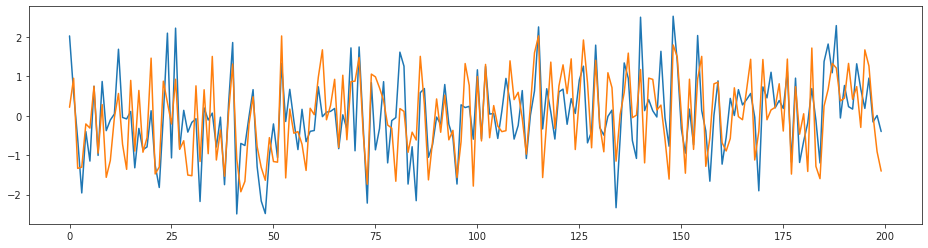

In [165]:
fig, ax = create_figure(figsize=(16, 4))
intvl = range(200)
ax.plot(sp_stats.zscore(z_vld.mean(0)[:, 6][intvl]))
ax.plot(-sp_stats.zscore(theta[intvl]))

In [171]:
sp_stats.pearsonr(z_vld.mean(0)[:, 11], heading[:, 2])

(0.4883216330680817, 0.0)

In [172]:
sp_stats.pearsonr(theta, heading[:, 2])

(-0.7550395076607881, 0.0)